In [4]:
!pip -q install timm

import os, shutil
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.auto import tqdm
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

CFG = {
    "image_size": 128,
    "batch_size": 256,
    "num_workers": 0,
    "epochs": 300,
    "lr": 1e-4,
    "weight_decay": 1e-6,
    "teacher_momentum": 0.996,
    "n_global_crops": 2,
    "n_local_crops": 2,
}


Device: cuda


In [ ]:
# Download TinyImageNet
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

TINY_ROOT = "/content/tiny-imagenet-200"
print("TinyImageNet root:", TINY_ROOT)

def prepare_tiny_imagenet(root):
    """
    Make TinyImageNet val/ compatible with torchvision.datasets.ImageFolder.
    """
    val_dir = os.path.join(root, "val")
    images_dir = os.path.join(val_dir, "images")
    anno_file = os.path.join(val_dir, "val_annotations.txt")

    if not os.path.exists(images_dir):
        print("val/ already prepared, skipping.")
        return

    print("Preparing val/ ...")
    img_to_wnid = {}
    with open(anno_file, "r") as f:
        for line in f:
            parts = line.strip().split('\t')
            img_name, wnid = parts[0], parts[1]
            img_to_wnid[img_name] = wnid

    for img_name, wnid in img_to_wnid.items():
        class_dir = os.path.join(val_dir, wnid)
        os.makedirs(class_dir, exist_ok=True)

        src = os.path.join(images_dir, img_name)
        dst = os.path.join(class_dir, img_name)
        if os.path.exists(src) and not os.path.exists(dst):
            shutil.move(src, dst)

    if os.path.isdir(images_dir) and len(os.listdir(images_dir)) == 0:
        os.rmdir(images_dir)
    print("Done preparing val/.")

prepare_tiny_imagenet(TINY_ROOT)


TinyImageNet root: /content/tiny-imagenet-200
val/ already prepared, skipping.


In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

class DinoMultiCropTransform:
    """
    DINO-style multi-crop augmentation:
    - 2 global crops
    - n_local_crops local crops
    """
    def __init__(self, size=64, n_global=2, n_local=2, mean=IMAGENET_MEAN, std=IMAGENET_STD):
        self.n_global = n_global
        self.n_local = n_local
        self.size = size

        flip_color = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
        ])

        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        # 2 global crops (scale 0.4–1.0)
        self.global_transforms = [
            transforms.Compose([
                transforms.RandomResizedCrop(
                    size, scale=(0.4, 1.0),
                    interpolation=transforms.InterpolationMode.BICUBIC,
                ),
                flip_color,
                transforms.GaussianBlur(kernel_size=15, sigma=(0.1, 2.0)),
                normalize,
            ]),
            transforms.Compose([
                transforms.RandomResizedCrop(
                    size, scale=(0.4, 1.0),
                    interpolation=transforms.InterpolationMode.BICUBIC,
                ),
                flip_color,
                transforms.GaussianBlur(kernel_size=15, sigma=(0.1, 2.0)),
                transforms.RandomSolarize(threshold=0.5, p=0.2),
                normalize,
            ]),
        ]

        # local crops (scale 0.08–0.4)
        self.local_transform = transforms.Compose([
            transforms.RandomResizedCrop(
                size, scale=(0.08, 0.4),
                interpolation=transforms.InterpolationMode.BICUBIC,
            ),
            flip_color,
            transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
            normalize,
        ])

    def __call__(self, x):
        crops = []
        for i in range(self.n_global):
            crops.append(self.global_transforms[i](x))
        for _ in range(self.n_local):
            crops.append(self.local_transform(x))
        return crops

# Unlabeled TinyImageNet for self-supervised DINO
dino_transform = DinoMultiCropTransform(
    size=CFG["image_size"],
    n_global=CFG["n_global_crops"],
    n_local=CFG["n_local_crops"],
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
)

tiny_train_unlabeled = datasets.ImageFolder(
    root=os.path.join(TINY_ROOT, "train"),
    transform=dino_transform,
)

pretrain_loader = DataLoader(
    tiny_train_unlabeled,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True,
    drop_last=True,
)

print("DINO pretrain images:", len(pretrain_loader.dataset))
print("Num classes (ignored for SSL):", len(tiny_train_unlabeled.classes))


DINO pretrain images: 100000
Num classes (ignored for SSL): 200


In [14]:
# ---- ViT-Tiny backbone ----
#Create model
def create_vit_tiny(img_size):
    model = timm.create_model(
        "vit_tiny_patch16_224",
        img_size=img_size,
        num_classes=0,
    )
    return model

student_backbone = create_vit_tiny(CFG["image_size"]).to(device)
teacher_backbone = create_vit_tiny(CFG["image_size"]).to(device)

# start teacher as copy of student
teacher_backbone.load_state_dict(student_backbone.state_dict())
for p in teacher_backbone.parameters():
    p.requires_grad = False

embed_dim = student_backbone.num_features
print("ViT tiny embed dim:", embed_dim)


class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim=1024, hidden_dim=2048, bottleneck_dim=256, n_layers=3):
        super().__init__()
        layers = []
        dim_in = in_dim
        for i in range(n_layers - 1):
            layers.append(nn.Linear(dim_in, hidden_dim))
            layers.append(nn.GELU())
            dim_in = hidden_dim
        layers.append(nn.Linear(dim_in, bottleneck_dim))
        self.mlp = nn.Sequential(*layers)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1.0)

    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1)
        x = self.last_layer(x)
        return x

out_dim = 1024  # dimension of DINO output/prototypes
student_head = DINOHead(embed_dim, out_dim=out_dim).to(device)
teacher_head = DINOHead(embed_dim, out_dim=out_dim).to(device)

teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters():
    p.requires_grad = False


class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global_crops, student_temp=0.1, teacher_temp=0.04, center_momentum=0.9):
        super().__init__()
        self.out_dim = out_dim
        self.n_global_crops = n_global_crops
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))

    def forward(self, student_outputs, teacher_outputs):
        """
        student_outputs: list of tensors [B, out_dim] for all crops (global+local)
        teacher_outputs: list of tensors [B, out_dim] for global crops only (length = n_global_crops)
        """
        # student log-probs
        student_logprobs = [
            F.log_softmax(s / self.student_temp, dim=-1)
            for s in student_outputs
        ]

        # teacher probs with centering
        teacher_probs = []
        for t in teacher_outputs:
            t = (t - self.center) / self.teacher_temp
            t = F.softmax(t, dim=-1)
            teacher_probs.append(t.detach())

        total_loss = 0.0
        n_loss_terms = 0

        # cross-entropy between teacher on global crops and student on all crops (except same view)
        for t_idx, t_prob in enumerate(teacher_probs):
            for s_idx, s_logprob in enumerate(student_logprobs):
                if s_idx == t_idx:
                    continue
                loss = -(t_prob * s_logprob).sum(dim=-1).mean()
                total_loss += loss
                n_loss_terms += 1

        total_loss /= n_loss_terms

        # update center
        batch_center = torch.cat(teacher_outputs, dim=0).mean(dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

        return total_loss

dino_loss_fn = DINOLoss(out_dim=out_dim, n_global_crops=CFG["n_global_crops"]).to(device)

# Optimizer: only student params (backbone + head)
params = list(student_backbone.parameters()) + list(student_head.parameters())
optimizer = torch.optim.AdamW(params, lr=CFG["lr"], weight_decay=CFG["weight_decay"])


ViT tiny embed dim: 192


/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
@torch.no_grad()
def update_teacher(student_backbone, teacher_backbone, student_head, teacher_head, m):
    for ps, pt in zip(student_backbone.parameters(), teacher_backbone.parameters()):
        pt.data.mul_(m).add_(ps.data, alpha=1.0 - m)
    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
        pt.data.mul_(m).add_(ps.data, alpha=1.0 - m)


In [1]:
import time

num_epochs = CFG["epochs"]

for epoch in range(1, num_epochs + 1):
    student_backbone.train()
    student_head.train()
    teacher_backbone.eval()
    teacher_head.eval()

    running_loss = 0.0
    n_steps = 0

    # start timer for this epoch
    epoch_start = time.time()

    pbar = tqdm(pretrain_loader, desc=f"[DINO] Epoch {epoch}/{num_epochs}", leave=False)

    for multi_crops, _ in pbar:
        crops = [img.to(device, non_blocking=True) for img in multi_crops]
        n_global = CFG["n_global_crops"]

        # ---- teacher on global crops ----
        with torch.no_grad():
            teacher_out = []
            for x in crops[:n_global]:
                feat_t = teacher_backbone(x)
                if feat_t.dim() > 2:
                    feat_t = feat_t.mean(dim=(2, 3))
                teacher_out.append(teacher_head(feat_t))

        # ---- student on all crops ----
        student_out = []
        for x in crops:
            feat_s = student_backbone(x)
            if feat_s.dim() > 2:
                feat_s = feat_s.mean(dim=(2, 3))
            student_out.append(student_head(feat_s))

        loss = dino_loss_fn(student_out, teacher_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_teacher(
            student_backbone, teacher_backbone,
            student_head, teacher_head,
            CFG["teacher_momentum"],
        )

        running_loss += loss.item()
        n_steps += 1
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    epoch_loss = running_loss / n_steps
    epoch_secs = time.time() - epoch_start

    print(f"Epoch {epoch:3d}: loss={epoch_loss:.4f}, time={epoch_secs:.1f}s\
n")

[DINO] Epoch 1/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   1: loss=10.9113, time=1540.6s

[DINO] Epoch 2/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   2: loss=10.8847, time=1551.0s

[DINO] Epoch 3/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   3: loss=10.8465, time=1676.4s

[DINO] Epoch 4/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   4: loss=10.8347, time=1699.3s

[DINO] Epoch 5/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   5: loss=10.8030, time=1525.8s

[DINO] Epoch 6/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   6: loss=10.7479, time=1736.5s

[DINO] Epoch 7/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   7: loss=10.7552, time=1534.5s

[DINO] Epoch 8/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   8: loss=10.7358, time=1511.3s

[DINO] Epoch 9/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch   9: loss=10.6833, time=1715.3s

[DINO] Epoch 10/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  10: loss=10.6319, time=1574.2s

[DINO] Epoch 11/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  11: loss=10.5895, time=1539.1s

[DINO] Epoch 12/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  12: loss=10.5651, time=1556.1s

[DINO] Epoch 13/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  13: loss=10.5685, time=1706.7s

[DINO] Epoch 14/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  14: loss=10.5023, time=1744.8s

[DINO] Epoch 15/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  15: loss=10.4675, time=1744.4s

[DINO] Epoch 16/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  16: loss=10.4343, time=1614.4s

[DINO] Epoch 17/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  17: loss=10.4517, time=1739.3s

[DINO] Epoch 18/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  18: loss=10.3934, time=1658.7s

[DINO] Epoch 19/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  19: loss=10.3561, time=1626.1s

[DINO] Epoch 20/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  20: loss=10.3493, time=1655.0s

[DINO] Epoch 21/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  21: loss=10.2843, time=1774.4s

[DINO] Epoch 22/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  22: loss=10.2618, time=1738.1s

[DINO] Epoch 23/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  23: loss=10.2689, time=1686.9s

[DINO] Epoch 24/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  24: loss=10.1998, time=1594.0s

[DINO] Epoch 25/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  25: loss=10.1794, time=1541.6s

[DINO] Epoch 26/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  26: loss=10.1689, time=1758.9s

[DINO] Epoch 27/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  27: loss=10.1403, time=1541.7s

[DINO] Epoch 28/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  28: loss=10.0772, time=1523.3s

[DINO] Epoch 29/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  29: loss=10.0555, time=1535.0s

[DINO] Epoch 30/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  30: loss=10.0411, time=1564.6s

[DINO] Epoch 31/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  31: loss=10.0317, time=1589.8s

[DINO] Epoch 32/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  32: loss=9.9914, time=1596.7s

[DINO] Epoch 33/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  33: loss=9.9292, time=1635.6s

[DINO] Epoch 34/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  34: loss=9.9172, time=1654.4s

[DINO] Epoch 35/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  35: loss=9.9046, time=1790.3s

[DINO] Epoch 36/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  36: loss=9.8407, time=1634.1s

[DINO] Epoch 37/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  37: loss=9.8433, time=1612.0s

[DINO] Epoch 38/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  38: loss=9.7702, time=1715.9s

[DINO] Epoch 39/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  39: loss=9.7709, time=1680.4s

[DINO] Epoch 40/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  40: loss=9.7365, time=1524.3s

[DINO] Epoch 41/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  41: loss=9.7270, time=1763.2s

[DINO] Epoch 42/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  42: loss=9.6634, time=1683.1s

[DINO] Epoch 43/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  43: loss=9.6266, time=1573.3s

[DINO] Epoch 44/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  44: loss=9.5866, time=1610.3s

[DINO] Epoch 45/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  45: loss=9.6072, time=1540.2s

[DINO] Epoch 46/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  46: loss=9.5431, time=1772.8s

[DINO] Epoch 47/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  47: loss=9.4893, time=1749.4s

[DINO] Epoch 48/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  48: loss=9.5015, time=1593.1s

[DINO] Epoch 49/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  49: loss=9.4540, time=1782.0s

[DINO] Epoch 50/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  50: loss=9.4319, time=1766.4s

[DINO] Epoch 51/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  51: loss=9.4045, time=1589.0s

[DINO] Epoch 52/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  52: loss=9.3436, time=1609.5s

[DINO] Epoch 53/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  53: loss=9.3401, time=1551.4s

[DINO] Epoch 54/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  54: loss=9.3269, time=1676.2s

[DINO] Epoch 55/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  55: loss=9.2709, time=1732.1s

[DINO] Epoch 56/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  56: loss=9.2620, time=1742.6s

[DINO] Epoch 57/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  57: loss=9.2308, time=1782.6s

[DINO] Epoch 58/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  58: loss=9.1778, time=1587.4s

[DINO] Epoch 59/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  59: loss=9.1708, time=1566.8s

[DINO] Epoch 60/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  60: loss=9.1233, time=1788.8s

[DINO] Epoch 61/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  61: loss=9.1067, time=1610.9s

[DINO] Epoch 62/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  62: loss=9.0692, time=1564.9s

[DINO] Epoch 63/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  63: loss=9.0156, time=1591.0s

[DINO] Epoch 64/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  64: loss=8.9974, time=1504.8s

[DINO] Epoch 65/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  65: loss=8.9725, time=1569.0s

[DINO] Epoch 66/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  66: loss=8.9416, time=1691.0s

[DINO] Epoch 67/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  67: loss=8.8968, time=1673.8s

[DINO] Epoch 68/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  68: loss=8.8745, time=1701.0s

[DINO] Epoch 69/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  69: loss=8.8602, time=1735.8s

[DINO] Epoch 70/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  70: loss=8.8028, time=1774.9s

[DINO] Epoch 71/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  71: loss=8.7664, time=1698.2s

[DINO] Epoch 72/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  72: loss=8.7679, time=1561.9s

[DINO] Epoch 73/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  73: loss=8.7334, time=1577.0s

[DINO] Epoch 74/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  74: loss=8.6631, time=1664.4s

[DINO] Epoch 75/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  75: loss=8.6451, time=1724.6s

[DINO] Epoch 76/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  76: loss=8.6400, time=1606.6s

[DINO] Epoch 77/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  77: loss=8.6250, time=1687.3s

[DINO] Epoch 78/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  78: loss=8.5603, time=1628.0s

[DINO] Epoch 79/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  79: loss=8.5153, time=1518.8s

[DINO] Epoch 80/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  80: loss=8.5100, time=1682.3s

[DINO] Epoch 81/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  81: loss=8.4945, time=1509.1s

[DINO] Epoch 82/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  82: loss=8.4447, time=1593.5s

[DINO] Epoch 83/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  83: loss=8.3967, time=1530.9s

[DINO] Epoch 84/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  84: loss=8.3708, time=1738.0s

[DINO] Epoch 85/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  85: loss=8.3688, time=1740.7s

[DINO] Epoch 86/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  86: loss=8.3336, time=1624.6s

[DINO] Epoch 87/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  87: loss=8.3185, time=1782.7s

[DINO] Epoch 88/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  88: loss=8.2492, time=1553.0s

[DINO] Epoch 89/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  89: loss=8.2275, time=1686.3s

[DINO] Epoch 90/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  90: loss=8.2098, time=1713.4s

[DINO] Epoch 91/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  91: loss=8.1571, time=1777.8s

[DINO] Epoch 92/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  92: loss=8.1210, time=1718.5s

[DINO] Epoch 93/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  93: loss=8.1258, time=1708.7s

[DINO] Epoch 94/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  94: loss=8.1012, time=1631.7s

[DINO] Epoch 95/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  95: loss=8.0436, time=1612.7s

[DINO] Epoch 96/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  96: loss=8.0487, time=1778.0s

[DINO] Epoch 97/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  97: loss=7.9655, time=1522.7s

[DINO] Epoch 98/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  98: loss=7.9473, time=1716.9s

[DINO] Epoch 99/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch  99: loss=7.9271, time=1685.1s

[DINO] Epoch 100/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 100: loss=7.9125, time=1650.9s

[DINO] Epoch 101/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 101: loss=7.8983, time=1557.8s

[DINO] Epoch 102/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 102: loss=7.8231, time=1591.6s

[DINO] Epoch 103/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 103: loss=7.7960, time=1594.0s

[DINO] Epoch 104/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 104: loss=7.7992, time=1510.4s

[DINO] Epoch 105/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 105: loss=7.7553, time=1644.0s

[DINO] Epoch 106/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 106: loss=7.7316, time=1772.2s

[DINO] Epoch 107/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 107: loss=7.6578, time=1513.0s

[DINO] Epoch 108/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 108: loss=7.6725, time=1691.3s

[DINO] Epoch 109/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 109: loss=7.5998, time=1500.9s

[DINO] Epoch 110/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 110: loss=7.5757, time=1745.9s

[DINO] Epoch 111/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 111: loss=7.5586, time=1635.7s

[DINO] Epoch 112/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 112: loss=7.5108, time=1641.8s

[DINO] Epoch 113/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 113: loss=7.4766, time=1699.8s

[DINO] Epoch 114/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 114: loss=7.4651, time=1572.6s

[DINO] Epoch 115/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 115: loss=7.4703, time=1667.8s

[DINO] Epoch 116/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 116: loss=7.3928, time=1758.2s

[DINO] Epoch 117/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 117: loss=7.4006, time=1750.4s

[DINO] Epoch 118/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 118: loss=7.3653, time=1604.3s

[DINO] Epoch 119/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 119: loss=7.3008, time=1620.0s

[DINO] Epoch 120/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 120: loss=7.2781, time=1531.4s

[DINO] Epoch 121/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 121: loss=7.2783, time=1570.8s

[DINO] Epoch 122/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 122: loss=7.2349, time=1612.4s

[DINO] Epoch 123/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 123: loss=7.1936, time=1736.7s

[DINO] Epoch 124/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 124: loss=7.1735, time=1767.8s

[DINO] Epoch 125/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 125: loss=7.1240, time=1633.3s

[DINO] Epoch 126/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 126: loss=7.1320, time=1724.1s

[DINO] Epoch 127/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 127: loss=7.0833, time=1600.6s

[DINO] Epoch 128/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 128: loss=7.0660, time=1621.6s

[DINO] Epoch 129/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 129: loss=6.9938, time=1561.1s

[DINO] Epoch 130/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 130: loss=7.0030, time=1558.0s

[DINO] Epoch 131/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 131: loss=6.9694, time=1596.0s

[DINO] Epoch 132/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 132: loss=6.9254, time=1765.3s

[DINO] Epoch 133/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 133: loss=6.9023, time=1615.3s

[DINO] Epoch 134/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 134: loss=6.8607, time=1756.3s

[DINO] Epoch 135/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 135: loss=6.8533, time=1554.4s

[DINO] Epoch 136/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 136: loss=6.8201, time=1754.9s

[DINO] Epoch 137/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 137: loss=6.7849, time=1654.6s

[DINO] Epoch 138/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 138: loss=6.7606, time=1655.9s

[DINO] Epoch 139/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 139: loss=6.7047, time=1645.8s

[DINO] Epoch 140/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 140: loss=6.6918, time=1579.4s

[DINO] Epoch 141/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 141: loss=6.6347, time=1586.2s

[DINO] Epoch 142/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 142: loss=6.6027, time=1603.8s

[DINO] Epoch 143/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 143: loss=6.6071, time=1799.8s

[DINO] Epoch 144/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 144: loss=6.5825, time=1706.3s

[DINO] Epoch 145/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 145: loss=6.5176, time=1518.1s

[DINO] Epoch 146/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 146: loss=6.4959, time=1769.3s

[DINO] Epoch 147/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 147: loss=6.4371, time=1539.7s

[DINO] Epoch 148/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 148: loss=6.4426, time=1752.2s

[DINO] Epoch 149/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 149: loss=6.4290, time=1521.8s

[DINO] Epoch 150/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 150: loss=6.3912, time=1564.7s

[DINO] Epoch 151/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 151: loss=6.3643, time=1551.8s

[DINO] Epoch 152/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 152: loss=6.3030, time=1772.3s

[DINO] Epoch 153/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 153: loss=6.2614, time=1736.5s

[DINO] Epoch 154/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 154: loss=6.2750, time=1788.6s

[DINO] Epoch 155/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 155: loss=6.2151, time=1683.5s

[DINO] Epoch 156/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 156: loss=6.1627, time=1652.4s

[DINO] Epoch 157/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 157: loss=6.1334, time=1706.5s

[DINO] Epoch 158/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 158: loss=6.1495, time=1590.1s

[DINO] Epoch 159/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 159: loss=6.0961, time=1679.5s

[DINO] Epoch 160/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 160: loss=6.0559, time=1794.0s

[DINO] Epoch 161/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 161: loss=6.0420, time=1615.4s

[DINO] Epoch 162/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 162: loss=6.0382, time=1714.1s

[DINO] Epoch 163/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 163: loss=5.9550, time=1745.9s

[DINO] Epoch 164/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 164: loss=5.9258, time=1533.8s

[DINO] Epoch 165/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 165: loss=5.9128, time=1642.8s

[DINO] Epoch 166/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 166: loss=5.8874, time=1698.1s

[DINO] Epoch 167/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 167: loss=5.8777, time=1735.4s

[DINO] Epoch 168/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 168: loss=5.8040, time=1513.6s

[DINO] Epoch 169/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 169: loss=5.7931, time=1717.1s

[DINO] Epoch 170/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 170: loss=5.7362, time=1770.8s

[DINO] Epoch 171/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 171: loss=5.7412, time=1596.2s

[DINO] Epoch 172/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 172: loss=5.7059, time=1554.3s

[DINO] Epoch 173/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 173: loss=5.6813, time=1797.7s

[DINO] Epoch 174/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 174: loss=5.6360, time=1760.6s

[DINO] Epoch 175/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 175: loss=5.5987, time=1632.9s

[DINO] Epoch 176/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 176: loss=5.5596, time=1733.0s

[DINO] Epoch 177/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 177: loss=5.5603, time=1555.7s

[DINO] Epoch 178/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 178: loss=5.4945, time=1703.2s

[DINO] Epoch 179/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 179: loss=5.4608, time=1662.4s

[DINO] Epoch 180/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 180: loss=5.4367, time=1721.6s

[DINO] Epoch 181/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 181: loss=5.4267, time=1505.6s

[DINO] Epoch 182/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 182: loss=5.4242, time=1763.8s

[DINO] Epoch 183/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 183: loss=5.3730, time=1531.7s

[DINO] Epoch 184/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 184: loss=5.3489, time=1520.9s

[DINO] Epoch 185/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 185: loss=5.2878, time=1530.8s

[DINO] Epoch 186/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 186: loss=5.2812, time=1641.3s

[DINO] Epoch 187/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 187: loss=5.2371, time=1545.6s

[DINO] Epoch 188/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 188: loss=5.2360, time=1500.4s

[DINO] Epoch 189/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 189: loss=5.2010, time=1735.2s

[DINO] Epoch 190/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 190: loss=5.1666, time=1735.9s

[DINO] Epoch 191/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 191: loss=5.1405, time=1724.6s

[DINO] Epoch 192/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 192: loss=5.0924, time=1644.8s

[DINO] Epoch 193/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 193: loss=5.0847, time=1571.5s

[DINO] Epoch 194/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 194: loss=5.0106, time=1791.3s

[DINO] Epoch 195/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 195: loss=4.9765, time=1566.5s

[DINO] Epoch 196/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 196: loss=4.9782, time=1689.7s

[DINO] Epoch 197/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 197: loss=4.9307, time=1692.1s

[DINO] Epoch 198/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 198: loss=4.8882, time=1702.5s

[DINO] Epoch 199/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 199: loss=4.9055, time=1703.2s

[DINO] Epoch 200/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 200: loss=4.8518, time=1560.8s

[DINO] Epoch 201/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 201: loss=4.7906, time=1559.4s

[DINO] Epoch 202/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 202: loss=4.8090, time=1529.4s

[DINO] Epoch 203/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 203: loss=4.7815, time=1586.5s

[DINO] Epoch 204/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 204: loss=4.7380, time=1535.7s

[DINO] Epoch 205/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 205: loss=4.7230, time=1709.5s

[DINO] Epoch 206/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 206: loss=4.6564, time=1711.7s

[DINO] Epoch 207/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 207: loss=4.6601, time=1528.9s

[DINO] Epoch 208/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 208: loss=4.5774, time=1633.1s

[DINO] Epoch 209/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 209: loss=4.6009, time=1645.6s

[DINO] Epoch 210/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 210: loss=4.5532, time=1537.0s

[DINO] Epoch 211/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 211: loss=4.5055, time=1656.8s

[DINO] Epoch 212/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 212: loss=4.4701, time=1672.6s

[DINO] Epoch 213/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 213: loss=4.4759, time=1622.1s

[DINO] Epoch 214/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 214: loss=4.4416, time=1577.7s

[DINO] Epoch 215/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 215: loss=4.4074, time=1697.7s

[DINO] Epoch 216/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 216: loss=4.3634, time=1558.8s

[DINO] Epoch 217/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 217: loss=4.3241, time=1532.9s

[DINO] Epoch 218/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 218: loss=4.2873, time=1750.3s

[DINO] Epoch 219/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 219: loss=4.2613, time=1693.9s

[DINO] Epoch 220/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 220: loss=4.2197, time=1558.5s

[DINO] Epoch 221/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 221: loss=4.2236, time=1610.5s

[DINO] Epoch 222/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 222: loss=4.1777, time=1506.2s

[DINO] Epoch 223/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 223: loss=4.1419, time=1518.3s

[DINO] Epoch 224/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 224: loss=4.1355, time=1559.7s

[DINO] Epoch 225/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 225: loss=4.0658, time=1513.1s

[DINO] Epoch 226/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 226: loss=4.0344, time=1546.2s

[DINO] Epoch 227/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 227: loss=4.0247, time=1556.6s

[DINO] Epoch 228/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 228: loss=3.9825, time=1701.0s

[DINO] Epoch 229/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 229: loss=3.9660, time=1691.8s

[DINO] Epoch 230/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 230: loss=3.9195, time=1510.0s

[DINO] Epoch 231/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 231: loss=3.8884, time=1721.4s

[DINO] Epoch 232/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 232: loss=3.8815, time=1716.3s

[DINO] Epoch 233/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 233: loss=3.8167, time=1560.1s

[DINO] Epoch 234/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 234: loss=3.7863, time=1670.8s

[DINO] Epoch 235/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 235: loss=3.8015, time=1559.1s

[DINO] Epoch 236/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 236: loss=3.7279, time=1762.3s

[DINO] Epoch 237/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 237: loss=3.7219, time=1578.3s

[DINO] Epoch 238/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 238: loss=3.6995, time=1553.8s

[DINO] Epoch 239/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 239: loss=3.6391, time=1695.5s

[DINO] Epoch 240/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 240: loss=3.6495, time=1634.0s

[DINO] Epoch 241/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 241: loss=3.5707, time=1605.2s

[DINO] Epoch 242/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 242: loss=3.5579, time=1654.7s

[DINO] Epoch 243/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 243: loss=3.5193, time=1568.5s

[DINO] Epoch 244/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 244: loss=3.4872, time=1691.5s

[DINO] Epoch 245/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 245: loss=3.4993, time=1647.2s

[DINO] Epoch 246/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 246: loss=3.4338, time=1611.1s

[DINO] Epoch 247/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 247: loss=3.4397, time=1519.2s

[DINO] Epoch 248/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 248: loss=3.3706, time=1647.2s

[DINO] Epoch 249/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 249: loss=3.3408, time=1519.8s

[DINO] Epoch 250/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 250: loss=3.3153, time=1631.2s

[DINO] Epoch 251/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 251: loss=3.2985, time=1755.2s

[DINO] Epoch 252/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 252: loss=3.2436, time=1695.9s

[DINO] Epoch 253/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 253: loss=3.2547, time=1739.1s

[DINO] Epoch 254/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 254: loss=3.1806, time=1518.5s

[DINO] Epoch 255/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 255: loss=3.1775, time=1759.4s

[DINO] Epoch 256/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 256: loss=3.1504, time=1552.3s

[DINO] Epoch 257/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 257: loss=3.1374, time=1691.9s

[DINO] Epoch 258/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 258: loss=3.0654, time=1636.1s

[DINO] Epoch 259/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 259: loss=3.0713, time=1782.6s

[DINO] Epoch 260/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 260: loss=3.0030, time=1750.1s

[DINO] Epoch 261/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 261: loss=2.9692, time=1778.6s

[DINO] Epoch 262/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 262: loss=2.9753, time=1515.5s

[DINO] Epoch 263/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 263: loss=2.9522, time=1679.1s

[DINO] Epoch 264/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 264: loss=2.9110, time=1714.2s

[DINO] Epoch 265/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 265: loss=2.8920, time=1749.5s

[DINO] Epoch 266/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 266: loss=2.8250, time=1528.8s

[DINO] Epoch 267/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 267: loss=2.7940, time=1794.5s

[DINO] Epoch 268/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 268: loss=2.8010, time=1515.7s

[DINO] Epoch 269/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 269: loss=2.7282, time=1623.2s

[DINO] Epoch 270/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 270: loss=2.7310, time=1625.2s

[DINO] Epoch 271/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 271: loss=2.6590, time=1767.4s

[DINO] Epoch 272/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 272: loss=2.6413, time=1559.4s

[DINO] Epoch 273/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 273: loss=2.6186, time=1716.7s

[DINO] Epoch 274/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 274: loss=2.6020, time=1745.9s

[DINO] Epoch 275/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 275: loss=2.5501, time=1592.2s

[DINO] Epoch 276/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 276: loss=2.5498, time=1683.9s

[DINO] Epoch 277/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 277: loss=2.4992, time=1747.3s

[DINO] Epoch 278/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 278: loss=2.4578, time=1661.2s

[DINO] Epoch 279/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 279: loss=2.4650, time=1696.0s

[DINO] Epoch 280/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 280: loss=2.3877, time=1606.2s

[DINO] Epoch 281/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 281: loss=2.3681, time=1535.7s

[DINO] Epoch 282/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 282: loss=2.3663, time=1559.7s

[DINO] Epoch 283/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 283: loss=2.2944, time=1710.3s

[DINO] Epoch 284/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 284: loss=2.2751, time=1682.3s

[DINO] Epoch 285/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 285: loss=2.2591, time=1717.6s

[DINO] Epoch 286/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 286: loss=2.2186, time=1549.4s

[DINO] Epoch 287/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 287: loss=2.2200, time=1680.2s

[DINO] Epoch 288/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 288: loss=2.1516, time=1727.5s

[DINO] Epoch 289/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 289: loss=2.1411, time=1572.5s

[DINO] Epoch 290/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 290: loss=2.1212, time=1564.9s

[DINO] Epoch 291/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 291: loss=2.0853, time=1765.7s

[DINO] Epoch 292/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 292: loss=2.0277, time=1788.4s

[DINO] Epoch 293/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 293: loss=2.0071, time=1527.5s

[DINO] Epoch 294/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 294: loss=1.9907, time=1579.9s

[DINO] Epoch 295/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 295: loss=1.9776, time=1691.8s

[DINO] Epoch 296/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 296: loss=1.8929, time=1630.9s

[DINO] Epoch 297/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 297: loss=1.9142, time=1598.6s

[DINO] Epoch 298/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 298: loss=1.8330, time=1597.9s

[DINO] Epoch 299/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 299: loss=1.8110, time=1573.0s

[DINO] Epoch 300/300:


  0%|          | 0/195 [00:00<?, ?it/s]


Epoch 300: loss=1.7720, time=1694.8s



In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# transforms for evaluation / linear probe
eval_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(CFG["image_size"], scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_val_transform = transforms.Compose([
    transforms.Resize(CFG["image_size"] + 8),
    transforms.CenterCrop(CFG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

tiny_train_eval = datasets.ImageFolder(
    root=os.path.join(TINY_ROOT, "train"),
    transform=eval_train_transform,
)

tiny_val_eval = datasets.ImageFolder(
    root=os.path.join(TINY_ROOT, "val"),
    transform=eval_val_transform,
)

num_classes = len(tiny_train_eval.classes)
print("TinyImageNet classes:", num_classes)
print("Train eval images:", len(tiny_train_eval))
print("Val eval images  :", len(tiny_val_eval))

train_eval_loader = DataLoader(
    tiny_train_eval,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True,
)

val_eval_loader = DataLoader(
    tiny_val_eval,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True,
)


TinyImageNet classes: 200
Train eval images: 100000
Val eval images  : 10000


In [ ]:
import torch
from tqdm.auto import tqdm

@torch.no_grad()
def extract_features(backbone, loader, device):
    backbone.eval()
    all_feats = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Extract", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        feats = backbone(images)
        # if shape is (B, C, H, W) (just in case), pool & flatten
        if feats.dim() > 2:
            feats = feats.mean(dim=(2, 3))
        all_feats.append(feats.cpu())
        all_labels.append(labels.cpu())

    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_feats, all_labels


In [6]:
!pip -q install scikit-learn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# use the DINO student backbone as frozen feature extractor
train_feats, train_labels = extract_features(student_backbone, train_eval_loader, device)
val_feats,   val_labels   = extract_features(student_backbone, val_eval_loader, device)

print("Train feats:", train_feats.shape)
print("Val feats  :", val_feats.shape)

k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
knn.fit(train_feats.numpy(), train_labels.numpy())

val_preds = knn.predict(val_feats.numpy())
knn_acc = accuracy_score(val_labels.numpy(), val_preds)
print(f"k-NN (k={k}) TinyImageNet val acc: {knn_acc*100:.2f}%")


Train feats: torch.Size([100000, 192])
Val feats  : torch.Size([10000, 192])
k-NN (k=5) TinyImageNet val acc: 53.04%


In [ ]:
import torch.nn as nn
import torch.optim as optim

class LinearProbe(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# figure out feature dim from one batch
with torch.no_grad():
    student_backbone.eval()
    sample_imgs, _ = next(iter(train_eval_loader))
    sample_imgs = sample_imgs.to(device)
    sample_feats = student_backbone(sample_imgs)
    if sample_feats.dim() > 2:
        sample_feats = sample_feats.mean(dim=(2, 3))
    feat_dim = sample_feats.shape[1]

print("Feature dim:", feat_dim)

linear_probe = LinearProbe(feat_dim, num_classes).to(device)

# freeze backbone
for p in student_backbone.parameters():
    p.requires_grad = False

criterion_lp = nn.CrossEntropyLoss()
optimizer_lp = optim.Adam(linear_probe.parameters(), lr=1e-3)
epochs_lp = 300  # adjust


Feature dim: 192


In [ ]:
def train_linear_epoch(backbone, head, loader, optimizer, criterion, device):
    backbone.eval()
    head.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="LP Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            feats = backbone(images)
            if feats.dim() > 2:
                feats = feats.mean(dim=(2, 3))

        logits = head(feats)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_linear_epoch(backbone, head, loader, criterion, device):
    backbone.eval()
    head.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="LP Val", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        feats = backbone(images)
        if feats.dim() > 2:
            feats = feats.mean(dim=(2, 3))

        logits = head(feats)
        loss = criterion(logits, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [3]:
import time

for epoch in range(1, epochs_lp + 1):
    print(f"[Linear Probe] Epoch {epoch}/{epochs_lp}:")

    epoch_start = time.time()

    train_loss, train_acc = train_linear_epoch(
        student_backbone, linear_probe,
        train_eval_loader, optimizer_lp, criterion_lp, device
    )
    val_loss, val_acc = eval_linear_epoch(
        student_backbone, linear_probe,
        val_eval_loader, criterion_lp, device
    )

    epoch_secs = time.time() - epoch_start

    print(
        f"Epoch {epoch:3d}: "
        f"train_loss={train_loss:.4f} | "
        f"train_acc={train_acc * 100:5.2f}% | "
        f"val_loss={val_loss:.4f}| "
        f"val_acc={val_acc * 100:5.2f}% | "
        f"time={epoch_secs:.1f}s\n"
    )


[Linear Probe] Epoch 1/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   1: train_loss=10.7749 | train_acc= 9.68% | val_loss=10.4370| val_acc= 7.66% | time=1347.9s

[Linear Probe] Epoch 2/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   2: train_loss=10.7410 | train_acc=10.23% | val_loss=10.3932| val_acc= 7.89% | time=1111.8s

[Linear Probe] Epoch 3/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   3: train_loss=10.7018 | train_acc=10.53% | val_loss=10.3767| val_acc= 9.23% | time=1236.4s

[Linear Probe] Epoch 4/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   4: train_loss=10.6784 | train_acc=11.10% | val_loss=10.4203| val_acc= 8.82% | time=1207.0s

[Linear Probe] Epoch 5/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   5: train_loss=10.6553 | train_acc=10.65% | val_loss=10.3428| val_acc= 9.17% | time=1138.3s

[Linear Probe] Epoch 6/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   6: train_loss=10.5585 | train_acc=11.77% | val_loss=10.3733| val_acc= 9.48% | time=1348.2s

[Linear Probe] Epoch 7/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   7: train_loss=10.5274 | train_acc=11.26% | val_loss=10.2952| val_acc= 9.79% | time=1159.6s

[Linear Probe] Epoch 8/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   8: train_loss=10.5517 | train_acc=11.50% | val_loss=10.2783| val_acc= 9.33% | time=1118.6s

[Linear Probe] Epoch 9/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch   9: train_loss=10.4995 | train_acc=11.26% | val_loss=10.2161| val_acc=10.04% | time=1413.0s

[Linear Probe] Epoch 10/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  10: train_loss=10.4931 | train_acc=10.51% | val_loss=10.1989| val_acc= 9.24% | time=1300.7s

[Linear Probe] Epoch 11/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  11: train_loss=10.4140 | train_acc=10.93% | val_loss=10.2318| val_acc=10.00% | time=1364.5s

[Linear Probe] Epoch 12/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  12: train_loss=10.3523 | train_acc=11.14% | val_loss=10.1707| val_acc=10.15% | time=1146.9s

[Linear Probe] Epoch 13/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  13: train_loss=10.3760 | train_acc=11.77% | val_loss=10.1027| val_acc= 9.85% | time=1204.3s

[Linear Probe] Epoch 14/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  14: train_loss=10.3705 | train_acc=11.24% | val_loss=10.1193| val_acc= 9.20% | time=1335.4s

[Linear Probe] Epoch 15/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  15: train_loss=10.3467 | train_acc=12.35% | val_loss=10.0422| val_acc=10.50% | time=1272.6s

[Linear Probe] Epoch 16/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  16: train_loss=10.2771 | train_acc=11.53% | val_loss=10.0074| val_acc=11.38% | time=1378.4s

[Linear Probe] Epoch 17/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  17: train_loss=10.2174 | train_acc=12.43% | val_loss=9.9664| val_acc=10.91% | time=1281.2s

[Linear Probe] Epoch 18/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  18: train_loss=10.2472 | train_acc=11.92% | val_loss=10.0222| val_acc=10.78% | time=1293.3s

[Linear Probe] Epoch 19/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  19: train_loss=10.1758 | train_acc=12.48% | val_loss=9.9906| val_acc=10.22% | time=1252.7s

[Linear Probe] Epoch 20/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  20: train_loss=10.2125 | train_acc=13.71% | val_loss=9.9285| val_acc=11.87% | time=1251.0s

[Linear Probe] Epoch 21/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  21: train_loss=10.0875 | train_acc=13.37% | val_loss=9.9047| val_acc=10.76% | time=1418.6s

[Linear Probe] Epoch 22/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  22: train_loss=10.0869 | train_acc=13.26% | val_loss=9.8958| val_acc=10.86% | time=1314.3s

[Linear Probe] Epoch 23/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  23: train_loss=10.0704 | train_acc=12.56% | val_loss=9.8332| val_acc=12.30% | time=1367.5s

[Linear Probe] Epoch 24/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  24: train_loss=9.9949 | train_acc=14.31% | val_loss=9.8044| val_acc=12.11% | time=1196.5s

[Linear Probe] Epoch 25/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  25: train_loss=9.9721 | train_acc=12.93% | val_loss=9.7971| val_acc=12.02% | time=1358.2s

[Linear Probe] Epoch 26/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  26: train_loss=9.9829 | train_acc=14.56% | val_loss=9.7069| val_acc=11.48% | time=1174.5s

[Linear Probe] Epoch 27/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  27: train_loss=9.9236 | train_acc=13.73% | val_loss=9.7150| val_acc=11.88% | time=1132.1s

[Linear Probe] Epoch 28/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  28: train_loss=9.9350 | train_acc=14.14% | val_loss=9.6559| val_acc=13.09% | time=1333.0s

[Linear Probe] Epoch 29/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  29: train_loss=9.9057 | train_acc=13.97% | val_loss=9.7155| val_acc=12.76% | time=1199.7s

[Linear Probe] Epoch 30/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  30: train_loss=9.8525 | train_acc=14.12% | val_loss=9.6427| val_acc=11.72% | time=1377.4s

[Linear Probe] Epoch 31/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  31: train_loss=9.8597 | train_acc=14.84% | val_loss=9.5764| val_acc=12.45% | time=1292.8s

[Linear Probe] Epoch 32/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  32: train_loss=9.8042 | train_acc=14.53% | val_loss=9.5895| val_acc=13.56% | time=1161.4s

[Linear Probe] Epoch 33/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  33: train_loss=9.7447 | train_acc=15.45% | val_loss=9.5437| val_acc=13.33% | time=1367.0s

[Linear Probe] Epoch 34/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  34: train_loss=9.7441 | train_acc=15.28% | val_loss=9.5284| val_acc=14.10% | time=1366.4s

[Linear Probe] Epoch 35/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  35: train_loss=9.7087 | train_acc=16.15% | val_loss=9.4702| val_acc=13.45% | time=1096.8s

[Linear Probe] Epoch 36/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  36: train_loss=9.6870 | train_acc=14.96% | val_loss=9.4674| val_acc=14.04% | time=1143.1s

[Linear Probe] Epoch 37/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  37: train_loss=9.6078 | train_acc=14.97% | val_loss=9.4837| val_acc=13.94% | time=1272.8s

[Linear Probe] Epoch 38/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  38: train_loss=9.6587 | train_acc=15.39% | val_loss=9.4078| val_acc=14.00% | time=1321.7s

[Linear Probe] Epoch 39/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  39: train_loss=9.5532 | train_acc=16.60% | val_loss=9.3842| val_acc=14.59% | time=1105.6s

[Linear Probe] Epoch 40/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  40: train_loss=9.5676 | train_acc=16.60% | val_loss=9.3954| val_acc=13.87% | time=1394.8s

[Linear Probe] Epoch 41/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  41: train_loss=9.5706 | train_acc=15.23% | val_loss=9.3175| val_acc=14.03% | time=1303.0s

[Linear Probe] Epoch 42/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  42: train_loss=9.5196 | train_acc=17.06% | val_loss=9.3407| val_acc=14.83% | time=1176.3s

[Linear Probe] Epoch 43/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  43: train_loss=9.4317 | train_acc=17.37% | val_loss=9.2501| val_acc=15.13% | time=1307.1s

[Linear Probe] Epoch 44/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  44: train_loss=9.4888 | train_acc=17.11% | val_loss=9.2502| val_acc=14.60% | time=1354.2s

[Linear Probe] Epoch 45/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  45: train_loss=9.4308 | train_acc=16.28% | val_loss=9.1968| val_acc=14.76% | time=1156.9s

[Linear Probe] Epoch 46/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  46: train_loss=9.4214 | train_acc=17.40% | val_loss=9.2160| val_acc=14.38% | time=1107.9s

[Linear Probe] Epoch 47/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  47: train_loss=9.3138 | train_acc=16.48% | val_loss=9.1741| val_acc=15.73% | time=1418.0s

[Linear Probe] Epoch 48/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  48: train_loss=9.3348 | train_acc=16.81% | val_loss=9.1108| val_acc=16.06% | time=1294.9s

[Linear Probe] Epoch 49/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  49: train_loss=9.2801 | train_acc=17.71% | val_loss=9.0833| val_acc=16.18% | time=1190.5s

[Linear Probe] Epoch 50/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  50: train_loss=9.2366 | train_acc=16.58% | val_loss=9.0459| val_acc=14.76% | time=1155.9s

[Linear Probe] Epoch 51/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  51: train_loss=9.2707 | train_acc=18.28% | val_loss=9.0285| val_acc=15.96% | time=1310.6s

[Linear Probe] Epoch 52/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  52: train_loss=9.1756 | train_acc=18.06% | val_loss=8.9724| val_acc=16.50% | time=1248.5s

[Linear Probe] Epoch 53/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  53: train_loss=9.1947 | train_acc=18.34% | val_loss=8.9648| val_acc=15.59% | time=1177.1s

[Linear Probe] Epoch 54/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  54: train_loss=9.1118 | train_acc=18.38% | val_loss=8.9403| val_acc=16.18% | time=1233.7s

[Linear Probe] Epoch 55/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  55: train_loss=9.1318 | train_acc=17.64% | val_loss=8.9221| val_acc=16.05% | time=1279.8s

[Linear Probe] Epoch 56/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  56: train_loss=9.0832 | train_acc=19.21% | val_loss=8.8889| val_acc=16.41% | time=1426.6s

[Linear Probe] Epoch 57/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  57: train_loss=9.0403 | train_acc=18.01% | val_loss=8.8608| val_acc=16.23% | time=1205.0s

[Linear Probe] Epoch 58/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  58: train_loss=9.0685 | train_acc=18.11% | val_loss=8.8155| val_acc=17.79% | time=1405.8s

[Linear Probe] Epoch 59/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  59: train_loss=8.9759 | train_acc=19.16% | val_loss=8.8520| val_acc=16.82% | time=1104.9s

[Linear Probe] Epoch 60/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  60: train_loss=8.9844 | train_acc=18.57% | val_loss=8.8093| val_acc=16.40% | time=1125.6s

[Linear Probe] Epoch 61/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  61: train_loss=8.9471 | train_acc=18.34% | val_loss=8.7120| val_acc=16.94% | time=1103.2s

[Linear Probe] Epoch 62/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  62: train_loss=8.9414 | train_acc=19.40% | val_loss=8.6788| val_acc=18.04% | time=1177.6s

[Linear Probe] Epoch 63/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  63: train_loss=8.8518 | train_acc=19.61% | val_loss=8.7246| val_acc=16.82% | time=1228.6s

[Linear Probe] Epoch 64/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  64: train_loss=8.8580 | train_acc=20.19% | val_loss=8.7060| val_acc=17.87% | time=1302.6s

[Linear Probe] Epoch 65/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  65: train_loss=8.8006 | train_acc=19.13% | val_loss=8.5912| val_acc=18.24% | time=1241.4s

[Linear Probe] Epoch 66/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  66: train_loss=8.8103 | train_acc=20.11% | val_loss=8.6037| val_acc=18.44% | time=1432.3s

[Linear Probe] Epoch 67/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  67: train_loss=8.7792 | train_acc=19.66% | val_loss=8.6073| val_acc=17.98% | time=1430.8s

[Linear Probe] Epoch 68/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  68: train_loss=8.7767 | train_acc=20.17% | val_loss=8.5044| val_acc=18.58% | time=1111.2s

[Linear Probe] Epoch 69/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  69: train_loss=8.6979 | train_acc=20.96% | val_loss=8.5367| val_acc=19.16% | time=1248.6s

[Linear Probe] Epoch 70/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  70: train_loss=8.6996 | train_acc=19.58% | val_loss=8.4779| val_acc=19.04% | time=1298.9s

[Linear Probe] Epoch 71/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  71: train_loss=8.6508 | train_acc=21.09% | val_loss=8.4393| val_acc=18.67% | time=1404.7s

[Linear Probe] Epoch 72/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  72: train_loss=8.6102 | train_acc=20.22% | val_loss=8.4297| val_acc=19.15% | time=1096.0s

[Linear Probe] Epoch 73/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  73: train_loss=8.5806 | train_acc=20.80% | val_loss=8.4507| val_acc=19.29% | time=1117.6s

[Linear Probe] Epoch 74/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  74: train_loss=8.5945 | train_acc=21.65% | val_loss=8.4208| val_acc=18.64% | time=1306.5s

[Linear Probe] Epoch 75/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  75: train_loss=8.5200 | train_acc=21.52% | val_loss=8.3173| val_acc=19.57% | time=1282.8s

[Linear Probe] Epoch 76/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  76: train_loss=8.4906 | train_acc=20.89% | val_loss=8.3316| val_acc=19.04% | time=1361.3s

[Linear Probe] Epoch 77/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  77: train_loss=8.4827 | train_acc=21.26% | val_loss=8.3247| val_acc=20.18% | time=1408.0s

[Linear Probe] Epoch 78/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  78: train_loss=8.4603 | train_acc=22.66% | val_loss=8.2652| val_acc=19.99% | time=1211.6s

[Linear Probe] Epoch 79/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  79: train_loss=8.4453 | train_acc=22.43% | val_loss=8.2537| val_acc=19.41% | time=1280.2s

[Linear Probe] Epoch 80/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  80: train_loss=8.3219 | train_acc=22.59% | val_loss=8.1634| val_acc=19.78% | time=1238.1s

[Linear Probe] Epoch 81/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  81: train_loss=8.3145 | train_acc=22.84% | val_loss=8.2218| val_acc=19.66% | time=1185.3s

[Linear Probe] Epoch 82/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  82: train_loss=8.2706 | train_acc=22.15% | val_loss=8.1691| val_acc=19.80% | time=1318.1s

[Linear Probe] Epoch 83/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  83: train_loss=8.2633 | train_acc=22.62% | val_loss=8.1665| val_acc=20.98% | time=1406.0s

[Linear Probe] Epoch 84/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  84: train_loss=8.2188 | train_acc=21.68% | val_loss=8.0464| val_acc=20.50% | time=1095.3s

[Linear Probe] Epoch 85/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  85: train_loss=8.1741 | train_acc=22.87% | val_loss=8.0519| val_acc=20.79% | time=1083.1s

[Linear Probe] Epoch 86/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  86: train_loss=8.2117 | train_acc=23.23% | val_loss=8.0230| val_acc=21.47% | time=1085.1s

[Linear Probe] Epoch 87/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  87: train_loss=8.1745 | train_acc=22.80% | val_loss=7.9837| val_acc=21.81% | time=1227.0s

[Linear Probe] Epoch 88/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  88: train_loss=8.1193 | train_acc=22.59% | val_loss=7.9448| val_acc=21.46% | time=1128.1s

[Linear Probe] Epoch 89/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  89: train_loss=8.1165 | train_acc=23.58% | val_loss=7.9827| val_acc=21.66% | time=1287.0s

[Linear Probe] Epoch 90/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  90: train_loss=8.0533 | train_acc=23.72% | val_loss=7.9626| val_acc=20.87% | time=1335.2s

[Linear Probe] Epoch 91/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  91: train_loss=8.0559 | train_acc=22.83% | val_loss=7.9147| val_acc=22.11% | time=1352.0s

[Linear Probe] Epoch 92/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  92: train_loss=7.9949 | train_acc=24.10% | val_loss=7.8282| val_acc=22.47% | time=1318.9s

[Linear Probe] Epoch 93/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  93: train_loss=7.9395 | train_acc=23.18% | val_loss=7.8163| val_acc=21.76% | time=1200.6s

[Linear Probe] Epoch 94/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  94: train_loss=7.9305 | train_acc=24.44% | val_loss=7.8000| val_acc=22.82% | time=1249.7s

[Linear Probe] Epoch 95/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  95: train_loss=7.9139 | train_acc=23.59% | val_loss=7.8097| val_acc=21.57% | time=1130.0s

[Linear Probe] Epoch 96/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  96: train_loss=7.9188 | train_acc=23.88% | val_loss=7.7394| val_acc=22.97% | time=1403.3s

[Linear Probe] Epoch 97/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  97: train_loss=7.8776 | train_acc=25.10% | val_loss=7.7447| val_acc=23.32% | time=1343.7s

[Linear Probe] Epoch 98/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  98: train_loss=7.7995 | train_acc=25.66% | val_loss=7.6778| val_acc=23.97% | time=1159.3s

[Linear Probe] Epoch 99/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch  99: train_loss=7.8358 | train_acc=24.63% | val_loss=7.6670| val_acc=22.32% | time=1118.9s

[Linear Probe] Epoch 100/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 100: train_loss=7.7701 | train_acc=24.41% | val_loss=7.5941| val_acc=22.68% | time=1197.1s

[Linear Probe] Epoch 101/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 101: train_loss=7.7741 | train_acc=24.44% | val_loss=7.5700| val_acc=22.56% | time=1184.3s

[Linear Probe] Epoch 102/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 102: train_loss=7.6955 | train_acc=25.34% | val_loss=7.5716| val_acc=24.44% | time=1252.8s

[Linear Probe] Epoch 103/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 103: train_loss=7.6664 | train_acc=26.06% | val_loss=7.5565| val_acc=23.99% | time=1322.4s

[Linear Probe] Epoch 104/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 104: train_loss=7.6658 | train_acc=25.73% | val_loss=7.5143| val_acc=23.45% | time=1221.5s

[Linear Probe] Epoch 105/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 105: train_loss=7.6638 | train_acc=25.93% | val_loss=7.5120| val_acc=23.93% | time=1270.6s

[Linear Probe] Epoch 106/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 106: train_loss=7.5456 | train_acc=26.88% | val_loss=7.5097| val_acc=23.97% | time=1198.2s

[Linear Probe] Epoch 107/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 107: train_loss=7.6116 | train_acc=25.76% | val_loss=7.3920| val_acc=24.92% | time=1218.6s

[Linear Probe] Epoch 108/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 108: train_loss=7.5440 | train_acc=26.11% | val_loss=7.3873| val_acc=25.33% | time=1282.0s

[Linear Probe] Epoch 109/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 109: train_loss=7.4780 | train_acc=25.73% | val_loss=7.3441| val_acc=24.03% | time=1417.7s

[Linear Probe] Epoch 110/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 110: train_loss=7.4977 | train_acc=25.59% | val_loss=7.3135| val_acc=23.92% | time=1200.7s

[Linear Probe] Epoch 111/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 111: train_loss=7.4842 | train_acc=27.28% | val_loss=7.3409| val_acc=25.78% | time=1324.1s

[Linear Probe] Epoch 112/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 112: train_loss=7.3744 | train_acc=25.86% | val_loss=7.3371| val_acc=24.20% | time=1112.7s

[Linear Probe] Epoch 113/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 113: train_loss=7.3750 | train_acc=26.09% | val_loss=7.2361| val_acc=25.26% | time=1343.0s

[Linear Probe] Epoch 114/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 114: train_loss=7.3054 | train_acc=27.24% | val_loss=7.1846| val_acc=24.73% | time=1316.5s

[Linear Probe] Epoch 115/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 115: train_loss=7.3312 | train_acc=26.57% | val_loss=7.2358| val_acc=24.65% | time=1234.1s

[Linear Probe] Epoch 116/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 116: train_loss=7.2730 | train_acc=28.09% | val_loss=7.2122| val_acc=25.13% | time=1391.6s

[Linear Probe] Epoch 117/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 117: train_loss=7.2417 | train_acc=28.19% | val_loss=7.1566| val_acc=25.96% | time=1118.6s

[Linear Probe] Epoch 118/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 118: train_loss=7.2802 | train_acc=27.80% | val_loss=7.1262| val_acc=25.43% | time=1361.4s

[Linear Probe] Epoch 119/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 119: train_loss=7.2147 | train_acc=27.81% | val_loss=7.0408| val_acc=26.78% | time=1109.2s

[Linear Probe] Epoch 120/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 120: train_loss=7.1819 | train_acc=28.33% | val_loss=7.0406| val_acc=25.40% | time=1082.1s

[Linear Probe] Epoch 121/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 121: train_loss=7.1131 | train_acc=28.82% | val_loss=7.0137| val_acc=27.29% | time=1199.0s

[Linear Probe] Epoch 122/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 122: train_loss=7.0693 | train_acc=27.70% | val_loss=7.0200| val_acc=26.29% | time=1257.0s

[Linear Probe] Epoch 123/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 123: train_loss=7.0712 | train_acc=27.65% | val_loss=6.9428| val_acc=26.17% | time=1109.0s

[Linear Probe] Epoch 124/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 124: train_loss=7.1027 | train_acc=28.15% | val_loss=6.9612| val_acc=27.55% | time=1382.2s

[Linear Probe] Epoch 125/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 125: train_loss=7.0068 | train_acc=28.80% | val_loss=6.9027| val_acc=27.84% | time=1393.0s

[Linear Probe] Epoch 126/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 126: train_loss=7.0282 | train_acc=29.63% | val_loss=6.9064| val_acc=27.17% | time=1366.5s

[Linear Probe] Epoch 127/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 127: train_loss=6.9893 | train_acc=29.93% | val_loss=6.8144| val_acc=27.93% | time=1148.3s

[Linear Probe] Epoch 128/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 128: train_loss=6.9809 | train_acc=30.07% | val_loss=6.7929| val_acc=27.28% | time=1358.4s

[Linear Probe] Epoch 129/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 129: train_loss=6.8804 | train_acc=30.24% | val_loss=6.7638| val_acc=27.18% | time=1319.4s

[Linear Probe] Epoch 130/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 130: train_loss=6.9076 | train_acc=29.88% | val_loss=6.7675| val_acc=27.77% | time=1376.5s

[Linear Probe] Epoch 131/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 131: train_loss=6.8613 | train_acc=29.43% | val_loss=6.7274| val_acc=28.66% | time=1136.1s

[Linear Probe] Epoch 132/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 132: train_loss=6.8116 | train_acc=29.59% | val_loss=6.7310| val_acc=28.10% | time=1126.9s

[Linear Probe] Epoch 133/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 133: train_loss=6.7729 | train_acc=30.10% | val_loss=6.6473| val_acc=28.91% | time=1346.3s

[Linear Probe] Epoch 134/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 134: train_loss=6.7913 | train_acc=30.27% | val_loss=6.6280| val_acc=29.24% | time=1335.0s

[Linear Probe] Epoch 135/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 135: train_loss=6.7308 | train_acc=31.07% | val_loss=6.6121| val_acc=28.67% | time=1417.4s

[Linear Probe] Epoch 136/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 136: train_loss=6.7268 | train_acc=31.08% | val_loss=6.6059| val_acc=29.78% | time=1091.9s

[Linear Probe] Epoch 137/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 137: train_loss=6.6919 | train_acc=29.89% | val_loss=6.5461| val_acc=29.77% | time=1367.7s

[Linear Probe] Epoch 138/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 138: train_loss=6.6854 | train_acc=31.44% | val_loss=6.5235| val_acc=28.20% | time=1302.2s

[Linear Probe] Epoch 139/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 139: train_loss=6.5883 | train_acc=31.20% | val_loss=6.5220| val_acc=29.26% | time=1264.5s

[Linear Probe] Epoch 140/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 140: train_loss=6.5752 | train_acc=30.13% | val_loss=6.4435| val_acc=30.29% | time=1290.1s

[Linear Probe] Epoch 141/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 141: train_loss=6.5176 | train_acc=32.15% | val_loss=6.4321| val_acc=29.61% | time=1199.8s

[Linear Probe] Epoch 142/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 142: train_loss=6.4819 | train_acc=31.17% | val_loss=6.3840| val_acc=30.24% | time=1221.3s

[Linear Probe] Epoch 143/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 143: train_loss=6.5032 | train_acc=30.53% | val_loss=6.3971| val_acc=29.13% | time=1424.2s

[Linear Probe] Epoch 144/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 144: train_loss=6.4394 | train_acc=32.07% | val_loss=6.4016| val_acc=30.05% | time=1353.2s

[Linear Probe] Epoch 145/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 145: train_loss=6.4784 | train_acc=30.93% | val_loss=6.3023| val_acc=29.53% | time=1318.2s

[Linear Probe] Epoch 146/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 146: train_loss=6.3934 | train_acc=32.37% | val_loss=6.2868| val_acc=29.44% | time=1333.2s

[Linear Probe] Epoch 147/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 147: train_loss=6.4017 | train_acc=31.15% | val_loss=6.3205| val_acc=30.16% | time=1432.2s

[Linear Probe] Epoch 148/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 148: train_loss=6.3679 | train_acc=31.43% | val_loss=6.2537| val_acc=29.83% | time=1339.7s

[Linear Probe] Epoch 149/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 149: train_loss=6.2947 | train_acc=33.31% | val_loss=6.2145| val_acc=30.57% | time=1131.8s

[Linear Probe] Epoch 150/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 150: train_loss=6.2396 | train_acc=31.67% | val_loss=6.1749| val_acc=31.73% | time=1299.8s

[Linear Probe] Epoch 151/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 151: train_loss=6.2337 | train_acc=33.34% | val_loss=6.1442| val_acc=30.85% | time=1128.2s

[Linear Probe] Epoch 152/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 152: train_loss=6.2409 | train_acc=33.79% | val_loss=6.1357| val_acc=30.62% | time=1264.9s

[Linear Probe] Epoch 153/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 153: train_loss=6.2285 | train_acc=32.72% | val_loss=6.0648| val_acc=31.03% | time=1257.3s

[Linear Probe] Epoch 154/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 154: train_loss=6.1548 | train_acc=33.42% | val_loss=6.1176| val_acc=30.74% | time=1154.5s

[Linear Probe] Epoch 155/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 155: train_loss=6.1348 | train_acc=32.63% | val_loss=6.0498| val_acc=31.89% | time=1184.9s

[Linear Probe] Epoch 156/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 156: train_loss=6.0723 | train_acc=32.69% | val_loss=6.0086| val_acc=32.30% | time=1335.6s

[Linear Probe] Epoch 157/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 157: train_loss=6.0327 | train_acc=33.33% | val_loss=6.0181| val_acc=31.44% | time=1143.8s

[Linear Probe] Epoch 158/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 158: train_loss=5.9963 | train_acc=33.43% | val_loss=5.9896| val_acc=32.70% | time=1301.9s

[Linear Probe] Epoch 159/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 159: train_loss=6.0589 | train_acc=34.64% | val_loss=5.8962| val_acc=33.08% | time=1387.5s

[Linear Probe] Epoch 160/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 160: train_loss=5.9335 | train_acc=34.47% | val_loss=5.8992| val_acc=32.59% | time=1319.1s

[Linear Probe] Epoch 161/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 161: train_loss=5.9931 | train_acc=34.48% | val_loss=5.9225| val_acc=32.74% | time=1396.2s

[Linear Probe] Epoch 162/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 162: train_loss=5.9073 | train_acc=34.50% | val_loss=5.8350| val_acc=32.53% | time=1171.0s

[Linear Probe] Epoch 163/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 163: train_loss=5.8938 | train_acc=35.10% | val_loss=5.7822| val_acc=33.07% | time=1432.1s

[Linear Probe] Epoch 164/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 164: train_loss=5.8645 | train_acc=34.84% | val_loss=5.7636| val_acc=32.20% | time=1295.4s

[Linear Probe] Epoch 165/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 165: train_loss=5.8679 | train_acc=33.94% | val_loss=5.7829| val_acc=33.99% | time=1132.5s

[Linear Probe] Epoch 166/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 166: train_loss=5.8502 | train_acc=35.43% | val_loss=5.7030| val_acc=33.06% | time=1171.4s

[Linear Probe] Epoch 167/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 167: train_loss=5.7712 | train_acc=35.36% | val_loss=5.6894| val_acc=34.20% | time=1383.3s

[Linear Probe] Epoch 168/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 168: train_loss=5.7315 | train_acc=36.10% | val_loss=5.6601| val_acc=34.32% | time=1203.4s

[Linear Probe] Epoch 169/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 169: train_loss=5.7008 | train_acc=35.50% | val_loss=5.6643| val_acc=34.76% | time=1221.5s

[Linear Probe] Epoch 170/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 170: train_loss=5.7155 | train_acc=34.56% | val_loss=5.5772| val_acc=34.39% | time=1123.4s

[Linear Probe] Epoch 171/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 171: train_loss=5.6500 | train_acc=34.83% | val_loss=5.5482| val_acc=34.61% | time=1175.2s

[Linear Probe] Epoch 172/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 172: train_loss=5.6239 | train_acc=34.90% | val_loss=5.5254| val_acc=35.18% | time=1192.8s

[Linear Probe] Epoch 173/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 173: train_loss=5.6035 | train_acc=35.13% | val_loss=5.5612| val_acc=34.30% | time=1109.9s

[Linear Probe] Epoch 174/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 174: train_loss=5.5648 | train_acc=36.34% | val_loss=5.5106| val_acc=34.98% | time=1323.3s

[Linear Probe] Epoch 175/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 175: train_loss=5.5055 | train_acc=36.73% | val_loss=5.4627| val_acc=34.35% | time=1306.1s

[Linear Probe] Epoch 176/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 176: train_loss=5.4879 | train_acc=36.11% | val_loss=5.4317| val_acc=35.56% | time=1084.5s

[Linear Probe] Epoch 177/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 177: train_loss=5.4577 | train_acc=36.37% | val_loss=5.3780| val_acc=34.68% | time=1286.1s

[Linear Probe] Epoch 178/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 178: train_loss=5.4780 | train_acc=36.45% | val_loss=5.3627| val_acc=35.24% | time=1344.7s

[Linear Probe] Epoch 179/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 179: train_loss=5.4605 | train_acc=36.70% | val_loss=5.3995| val_acc=35.24% | time=1282.7s

[Linear Probe] Epoch 180/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 180: train_loss=5.4002 | train_acc=36.35% | val_loss=5.3758| val_acc=35.24% | time=1330.6s

[Linear Probe] Epoch 181/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 181: train_loss=5.3513 | train_acc=37.33% | val_loss=5.3096| val_acc=36.31% | time=1272.5s

[Linear Probe] Epoch 182/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 182: train_loss=5.2773 | train_acc=36.96% | val_loss=5.3185| val_acc=34.95% | time=1340.0s

[Linear Probe] Epoch 183/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 183: train_loss=5.3015 | train_acc=37.07% | val_loss=5.2743| val_acc=36.43% | time=1428.3s

[Linear Probe] Epoch 184/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 184: train_loss=5.2798 | train_acc=36.73% | val_loss=5.2317| val_acc=35.76% | time=1145.5s

[Linear Probe] Epoch 185/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 185: train_loss=5.2389 | train_acc=37.55% | val_loss=5.2135| val_acc=36.87% | time=1202.4s

[Linear Probe] Epoch 186/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 186: train_loss=5.2311 | train_acc=38.29% | val_loss=5.1616| val_acc=36.11% | time=1417.4s

[Linear Probe] Epoch 187/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 187: train_loss=5.1451 | train_acc=37.09% | val_loss=5.1267| val_acc=37.62% | time=1345.5s

[Linear Probe] Epoch 188/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 188: train_loss=5.1119 | train_acc=39.13% | val_loss=5.0814| val_acc=36.26% | time=1254.2s

[Linear Probe] Epoch 189/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 189: train_loss=5.0962 | train_acc=39.12% | val_loss=5.0531| val_acc=36.63% | time=1093.4s

[Linear Probe] Epoch 190/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 190: train_loss=5.0925 | train_acc=38.35% | val_loss=5.0480| val_acc=37.09% | time=1086.0s

[Linear Probe] Epoch 191/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 191: train_loss=5.0058 | train_acc=39.31% | val_loss=4.9983| val_acc=36.69% | time=1357.6s

[Linear Probe] Epoch 192/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 192: train_loss=5.0248 | train_acc=37.80% | val_loss=4.9897| val_acc=37.91% | time=1292.1s

[Linear Probe] Epoch 193/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 193: train_loss=4.9547 | train_acc=38.28% | val_loss=4.9584| val_acc=37.83% | time=1295.4s

[Linear Probe] Epoch 194/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 194: train_loss=4.9345 | train_acc=39.29% | val_loss=4.8950| val_acc=37.28% | time=1179.1s

[Linear Probe] Epoch 195/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 195: train_loss=4.9353 | train_acc=39.62% | val_loss=4.9361| val_acc=38.40% | time=1306.1s

[Linear Probe] Epoch 196/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 196: train_loss=4.9478 | train_acc=39.16% | val_loss=4.9053| val_acc=37.34% | time=1306.6s

[Linear Probe] Epoch 197/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 197: train_loss=4.8964 | train_acc=38.94% | val_loss=4.8043| val_acc=38.13% | time=1308.2s

[Linear Probe] Epoch 198/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 198: train_loss=4.8114 | train_acc=40.46% | val_loss=4.8662| val_acc=38.98% | time=1239.2s

[Linear Probe] Epoch 199/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 199: train_loss=4.8367 | train_acc=40.43% | val_loss=4.7739| val_acc=38.77% | time=1157.4s

[Linear Probe] Epoch 200/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 200: train_loss=4.8263 | train_acc=40.04% | val_loss=4.8107| val_acc=38.72% | time=1316.7s

[Linear Probe] Epoch 201/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 201: train_loss=4.7611 | train_acc=40.66% | val_loss=4.7667| val_acc=37.83% | time=1226.2s

[Linear Probe] Epoch 202/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 202: train_loss=4.7567 | train_acc=41.22% | val_loss=4.7479| val_acc=38.19% | time=1251.8s

[Linear Probe] Epoch 203/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 203: train_loss=4.6866 | train_acc=40.88% | val_loss=4.7228| val_acc=39.12% | time=1109.8s

[Linear Probe] Epoch 204/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 204: train_loss=4.6319 | train_acc=41.59% | val_loss=4.6916| val_acc=39.40% | time=1438.6s

[Linear Probe] Epoch 205/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 205: train_loss=4.6299 | train_acc=40.93% | val_loss=4.6203| val_acc=39.05% | time=1269.7s

[Linear Probe] Epoch 206/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 206: train_loss=4.5798 | train_acc=40.74% | val_loss=4.6417| val_acc=39.05% | time=1368.6s

[Linear Probe] Epoch 207/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 207: train_loss=4.6258 | train_acc=41.36% | val_loss=4.5411| val_acc=39.31% | time=1114.1s

[Linear Probe] Epoch 208/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 208: train_loss=4.5369 | train_acc=42.08% | val_loss=4.5379| val_acc=40.31% | time=1113.4s

[Linear Probe] Epoch 209/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 209: train_loss=4.5259 | train_acc=41.96% | val_loss=4.4917| val_acc=40.24% | time=1410.5s

[Linear Probe] Epoch 210/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 210: train_loss=4.4559 | train_acc=40.63% | val_loss=4.4495| val_acc=40.48% | time=1323.6s

[Linear Probe] Epoch 211/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 211: train_loss=4.4629 | train_acc=41.68% | val_loss=4.4278| val_acc=40.54% | time=1431.8s

[Linear Probe] Epoch 212/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 212: train_loss=4.4726 | train_acc=41.66% | val_loss=4.4685| val_acc=40.70% | time=1388.7s

[Linear Probe] Epoch 213/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 213: train_loss=4.4392 | train_acc=41.14% | val_loss=4.3679| val_acc=39.97% | time=1410.4s

[Linear Probe] Epoch 214/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 214: train_loss=4.3674 | train_acc=41.64% | val_loss=4.3865| val_acc=40.98% | time=1245.0s

[Linear Probe] Epoch 215/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 215: train_loss=4.3147 | train_acc=42.40% | val_loss=4.3036| val_acc=41.67% | time=1425.9s

[Linear Probe] Epoch 216/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 216: train_loss=4.2793 | train_acc=42.57% | val_loss=4.2730| val_acc=41.11% | time=1212.4s

[Linear Probe] Epoch 217/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 217: train_loss=4.2806 | train_acc=42.28% | val_loss=4.2530| val_acc=40.38% | time=1315.2s

[Linear Probe] Epoch 218/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 218: train_loss=4.2969 | train_acc=42.44% | val_loss=4.2664| val_acc=41.60% | time=1212.0s

[Linear Probe] Epoch 219/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 219: train_loss=4.2321 | train_acc=42.66% | val_loss=4.1843| val_acc=42.04% | time=1379.3s

[Linear Probe] Epoch 220/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 220: train_loss=4.2252 | train_acc=43.72% | val_loss=4.2390| val_acc=42.37% | time=1290.2s

[Linear Probe] Epoch 221/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 221: train_loss=4.1720 | train_acc=42.87% | val_loss=4.2088| val_acc=42.62% | time=1138.9s

[Linear Probe] Epoch 222/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 222: train_loss=4.0912 | train_acc=43.54% | val_loss=4.1087| val_acc=42.32% | time=1332.8s

[Linear Probe] Epoch 223/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 223: train_loss=4.0669 | train_acc=43.66% | val_loss=4.1271| val_acc=42.88% | time=1398.9s

[Linear Probe] Epoch 224/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 224: train_loss=4.0376 | train_acc=44.14% | val_loss=4.0309| val_acc=42.10% | time=1434.4s

[Linear Probe] Epoch 225/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 225: train_loss=4.0111 | train_acc=44.10% | val_loss=4.0774| val_acc=43.09% | time=1377.9s

[Linear Probe] Epoch 226/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 226: train_loss=4.0053 | train_acc=43.36% | val_loss=4.0260| val_acc=42.46% | time=1258.2s

[Linear Probe] Epoch 227/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 227: train_loss=3.9502 | train_acc=43.43% | val_loss=4.0375| val_acc=42.07% | time=1080.0s

[Linear Probe] Epoch 228/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 228: train_loss=3.9872 | train_acc=43.69% | val_loss=3.9654| val_acc=43.50% | time=1351.4s

[Linear Probe] Epoch 229/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 229: train_loss=3.9224 | train_acc=44.85% | val_loss=3.9367| val_acc=42.17% | time=1377.6s

[Linear Probe] Epoch 230/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 230: train_loss=3.8453 | train_acc=44.74% | val_loss=3.9285| val_acc=43.08% | time=1133.8s

[Linear Probe] Epoch 231/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 231: train_loss=3.9096 | train_acc=44.47% | val_loss=3.9067| val_acc=43.63% | time=1120.9s

[Linear Probe] Epoch 232/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 232: train_loss=3.8321 | train_acc=45.79% | val_loss=3.8417| val_acc=42.69% | time=1229.2s

[Linear Probe] Epoch 233/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 233: train_loss=3.7890 | train_acc=44.12% | val_loss=3.8126| val_acc=42.77% | time=1317.7s

[Linear Probe] Epoch 234/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 234: train_loss=3.7911 | train_acc=45.92% | val_loss=3.8238| val_acc=43.74% | time=1369.3s

[Linear Probe] Epoch 235/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 235: train_loss=3.7255 | train_acc=45.50% | val_loss=3.7475| val_acc=44.51% | time=1364.7s

[Linear Probe] Epoch 236/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 236: train_loss=3.6944 | train_acc=45.63% | val_loss=3.7246| val_acc=44.88% | time=1231.3s

[Linear Probe] Epoch 237/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 237: train_loss=3.6820 | train_acc=44.97% | val_loss=3.7126| val_acc=44.69% | time=1174.1s

[Linear Probe] Epoch 238/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 238: train_loss=3.6909 | train_acc=46.04% | val_loss=3.6828| val_acc=43.98% | time=1299.1s

[Linear Probe] Epoch 239/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 239: train_loss=3.6484 | train_acc=45.87% | val_loss=3.6916| val_acc=43.79% | time=1228.7s

[Linear Probe] Epoch 240/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 240: train_loss=3.5978 | train_acc=45.38% | val_loss=3.6152| val_acc=45.37% | time=1165.2s

[Linear Probe] Epoch 241/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 241: train_loss=3.5556 | train_acc=47.07% | val_loss=3.6042| val_acc=44.24% | time=1313.4s

[Linear Probe] Epoch 242/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 242: train_loss=3.5250 | train_acc=46.75% | val_loss=3.5539| val_acc=45.31% | time=1175.3s

[Linear Probe] Epoch 243/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 243: train_loss=3.5370 | train_acc=45.66% | val_loss=3.5557| val_acc=44.62% | time=1196.6s

[Linear Probe] Epoch 244/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 244: train_loss=3.4909 | train_acc=46.36% | val_loss=3.4680| val_acc=44.75% | time=1150.3s

[Linear Probe] Epoch 245/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 245: train_loss=3.4701 | train_acc=46.28% | val_loss=3.4324| val_acc=46.12% | time=1116.0s

[Linear Probe] Epoch 246/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 246: train_loss=3.3630 | train_acc=47.85% | val_loss=3.4141| val_acc=46.31% | time=1122.3s

[Linear Probe] Epoch 247/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 247: train_loss=3.4081 | train_acc=46.24% | val_loss=3.4490| val_acc=45.24% | time=1247.8s

[Linear Probe] Epoch 248/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 248: train_loss=3.3252 | train_acc=46.36% | val_loss=3.4043| val_acc=46.08% | time=1385.3s

[Linear Probe] Epoch 249/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 249: train_loss=3.3000 | train_acc=47.83% | val_loss=3.3919| val_acc=46.41% | time=1210.0s

[Linear Probe] Epoch 250/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 250: train_loss=3.3066 | train_acc=46.72% | val_loss=3.3684| val_acc=46.63% | time=1130.0s

[Linear Probe] Epoch 251/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 251: train_loss=3.2753 | train_acc=47.95% | val_loss=3.2560| val_acc=45.73% | time=1096.1s

[Linear Probe] Epoch 252/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 252: train_loss=3.1840 | train_acc=48.01% | val_loss=3.3114| val_acc=46.18% | time=1270.9s

[Linear Probe] Epoch 253/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 253: train_loss=3.2211 | train_acc=48.10% | val_loss=3.2769| val_acc=46.63% | time=1299.2s

[Linear Probe] Epoch 254/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 254: train_loss=3.1437 | train_acc=47.76% | val_loss=3.2014| val_acc=46.14% | time=1234.0s

[Linear Probe] Epoch 255/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 255: train_loss=3.1137 | train_acc=48.04% | val_loss=3.1938| val_acc=47.26% | time=1326.5s

[Linear Probe] Epoch 256/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 256: train_loss=3.0699 | train_acc=47.42% | val_loss=3.2112| val_acc=47.00% | time=1126.6s

[Linear Probe] Epoch 257/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 257: train_loss=3.1261 | train_acc=47.88% | val_loss=3.1589| val_acc=46.90% | time=1273.9s

[Linear Probe] Epoch 258/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 258: train_loss=3.0625 | train_acc=48.03% | val_loss=3.0623| val_acc=46.74% | time=1183.4s

[Linear Probe] Epoch 259/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 259: train_loss=2.9970 | train_acc=49.28% | val_loss=3.1206| val_acc=48.18% | time=1178.0s

[Linear Probe] Epoch 260/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 260: train_loss=2.9718 | train_acc=48.90% | val_loss=3.0302| val_acc=48.16% | time=1215.9s

[Linear Probe] Epoch 261/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 261: train_loss=2.9276 | train_acc=49.82% | val_loss=2.9868| val_acc=47.51% | time=1217.3s

[Linear Probe] Epoch 262/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 262: train_loss=2.8877 | train_acc=49.29% | val_loss=2.9774| val_acc=47.70% | time=1216.1s

[Linear Probe] Epoch 263/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 263: train_loss=2.9166 | train_acc=50.43% | val_loss=2.9642| val_acc=48.18% | time=1305.3s

[Linear Probe] Epoch 264/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 264: train_loss=2.8934 | train_acc=50.24% | val_loss=2.8919| val_acc=49.06% | time=1160.2s

[Linear Probe] Epoch 265/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 265: train_loss=2.8698 | train_acc=48.76% | val_loss=2.9130| val_acc=48.75% | time=1246.6s

[Linear Probe] Epoch 266/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 266: train_loss=2.8160 | train_acc=50.68% | val_loss=2.8603| val_acc=48.93% | time=1248.6s

[Linear Probe] Epoch 267/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 267: train_loss=2.7758 | train_acc=50.09% | val_loss=2.8871| val_acc=48.15% | time=1147.6s

[Linear Probe] Epoch 268/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 268: train_loss=2.7213 | train_acc=50.94% | val_loss=2.8602| val_acc=49.59% | time=1284.1s

[Linear Probe] Epoch 269/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 269: train_loss=2.7611 | train_acc=50.55% | val_loss=2.7777| val_acc=49.24% | time=1438.6s

[Linear Probe] Epoch 270/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 270: train_loss=2.6646 | train_acc=50.99% | val_loss=2.7789| val_acc=49.19% | time=1307.1s

[Linear Probe] Epoch 271/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 271: train_loss=2.6338 | train_acc=51.43% | val_loss=2.7423| val_acc=49.10% | time=1108.6s

[Linear Probe] Epoch 272/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 272: train_loss=2.6588 | train_acc=50.55% | val_loss=2.7417| val_acc=49.86% | time=1271.6s

[Linear Probe] Epoch 273/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 273: train_loss=2.6092 | train_acc=51.50% | val_loss=2.6642| val_acc=49.14% | time=1246.6s

[Linear Probe] Epoch 274/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 274: train_loss=2.5729 | train_acc=51.38% | val_loss=2.6319| val_acc=50.04% | time=1080.4s

[Linear Probe] Epoch 275/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 275: train_loss=2.5203 | train_acc=50.52% | val_loss=2.6616| val_acc=49.56% | time=1105.9s

[Linear Probe] Epoch 276/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 276: train_loss=2.4759 | train_acc=51.82% | val_loss=2.5843| val_acc=49.99% | time=1377.0s

[Linear Probe] Epoch 277/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 277: train_loss=2.5144 | train_acc=52.22% | val_loss=2.6062| val_acc=49.70% | time=1186.7s

[Linear Probe] Epoch 278/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 278: train_loss=2.4393 | train_acc=51.87% | val_loss=2.5424| val_acc=50.73% | time=1340.1s

[Linear Probe] Epoch 279/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 279: train_loss=2.4677 | train_acc=51.23% | val_loss=2.5252| val_acc=50.58% | time=1376.8s

[Linear Probe] Epoch 280/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 280: train_loss=2.4343 | train_acc=52.13% | val_loss=2.4706| val_acc=50.00% | time=1282.3s

[Linear Probe] Epoch 281/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 281: train_loss=2.3786 | train_acc=53.13% | val_loss=2.4423| val_acc=51.44% | time=1377.9s

[Linear Probe] Epoch 282/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 282: train_loss=2.3171 | train_acc=52.31% | val_loss=2.3949| val_acc=51.47% | time=1352.9s

[Linear Probe] Epoch 283/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 283: train_loss=2.3372 | train_acc=52.67% | val_loss=2.4289| val_acc=52.09% | time=1168.7s

[Linear Probe] Epoch 284/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 284: train_loss=2.2585 | train_acc=52.22% | val_loss=2.3657| val_acc=50.72% | time=1389.7s

[Linear Probe] Epoch 285/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 285: train_loss=2.2819 | train_acc=53.56% | val_loss=2.3050| val_acc=50.81% | time=1416.6s

[Linear Probe] Epoch 286/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 286: train_loss=2.1777 | train_acc=52.88% | val_loss=2.3090| val_acc=51.94% | time=1326.6s

[Linear Probe] Epoch 287/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 287: train_loss=2.2291 | train_acc=53.04% | val_loss=2.2483| val_acc=51.83% | time=1198.6s

[Linear Probe] Epoch 288/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 288: train_loss=2.1647 | train_acc=52.52% | val_loss=2.2661| val_acc=51.49% | time=1433.9s

[Linear Probe] Epoch 289/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 289: train_loss=2.1048 | train_acc=52.60% | val_loss=2.1828| val_acc=52.97% | time=1225.4s

[Linear Probe] Epoch 290/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 290: train_loss=2.0533 | train_acc=52.98% | val_loss=2.1369| val_acc=53.19% | time=1298.1s

[Linear Probe] Epoch 291/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 291: train_loss=2.0959 | train_acc=53.06% | val_loss=2.2072| val_acc=51.81% | time=1302.0s

[Linear Probe] Epoch 292/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 292: train_loss=2.0082 | train_acc=54.55% | val_loss=2.1005| val_acc=51.90% | time=1405.8s

[Linear Probe] Epoch 293/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 293: train_loss=1.9607 | train_acc=53.88% | val_loss=2.1182| val_acc=52.19% | time=1203.1s

[Linear Probe] Epoch 294/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 294: train_loss=1.9712 | train_acc=54.70% | val_loss=2.0510| val_acc=52.73% | time=1144.9s

[Linear Probe] Epoch 295/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 295: train_loss=1.9044 | train_acc=54.01% | val_loss=2.0686| val_acc=52.55% | time=1323.4s

[Linear Probe] Epoch 296/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 296: train_loss=1.8885 | train_acc=54.50% | val_loss=2.0288| val_acc=53.89% | time=1417.7s

[Linear Probe] Epoch 297/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 297: train_loss=1.8797 | train_acc=54.96% | val_loss=1.9389| val_acc=53.85% | time=1217.8s

[Linear Probe] Epoch 298/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 298: train_loss=1.8999 | train_acc=55.05% | val_loss=1.9298| val_acc=53.00% | time=1389.3s

[Linear Probe] Epoch 299/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 299: train_loss=1.8552 | train_acc=54.11% | val_loss=1.9190| val_acc=53.56% | time=1386.8s

[Linear Probe] Epoch 300/300:


  0%|           0/195 [00:00<?, 0.00s/it]

Epoch 300: train_loss=1.8018 | train_acc=55.73% | val_loss=1.8709| val_acc=54.29% | time=1240.5s



In [7]:
!pip install --quiet timm

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
# Data transforms (DINO-style ImageNet normalization)
img_transform = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225],
)

stl_train = datasets.STL10(root="./data", split="train", download=True, transform=img_transform)
stl_test  = datasets.STL10(root="./data", split="test",  download=True, transform=img_transform)

train_loader = DataLoader(stl_train, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(stl_test,  batch_size=128, shuffle=False, num_workers=2)

print("STL-10 train:", len(stl_train), "test:", len(stl_test))


100%|██████████| 2.64G/2.64G [03:38<00:00, 12.1MB/s]


STL-10 train: 5000 test: 8000


In [ ]:
def tensor_to_pil(img_tensor):
    img = inv_normalize(img_tensor.cpu())
    img = torch.clamp(img, 0, 1)
    return transforms.ToPILImage()(img)

def show_side_by_side(images, titles=None, figsize=(12,4), cmap_list=None):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3:
                img = np.transpose(img, (1,2,0))
        if cmap_list is not None and cmap_list[i] is not None:
            plt.imshow(img, cmap=cmap_list[i])
        else:
            plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
def get_last_selfattention(model, img_batch):
    """
    img_batch: [B,3,H,W], normalized
    returns: [B, num_heads, N_tokens, N_tokens]
    """
    with torch.no_grad():
        attn = model.get_last_selfattention(img_batch)
    return attn


heads: 6 grid: 14 x 14


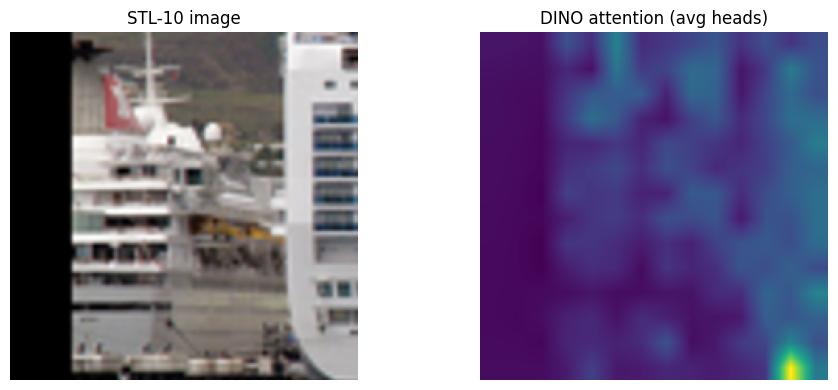

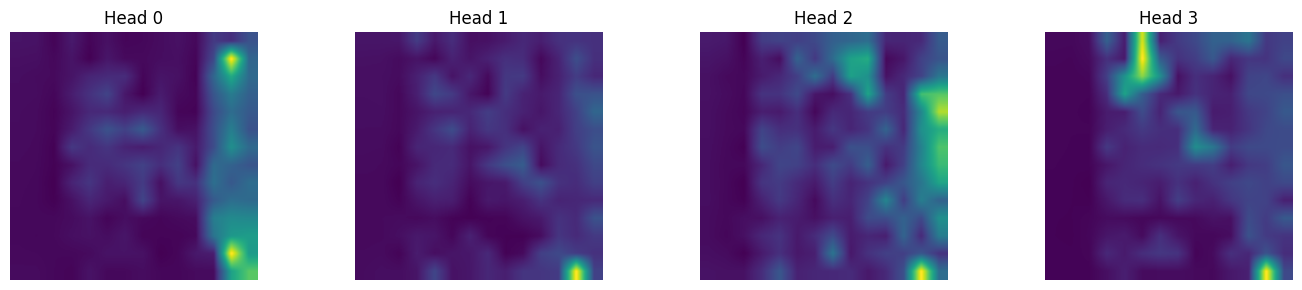

In [ ]:
def visualize_dino_attention_random():
    # sample one image
    img_tensor, label = stl_test[np.random.randint(len(stl_test))]
    x = img_tensor.unsqueeze(0).to(device)         # [1,3,224,224]

    # get attention
    attn = get_last_selfattention(model, x)        # [1, heads, N, N]
    attn = attn[0]                                 # [heads,N,N]
    num_heads, N, _ = attn.shape

    num_patches = N - 1                            # ignore CLS
    grid_size = int(math.sqrt(num_patches))        # e.g., 14x14
    print("heads:", num_heads, "grid:", grid_size, "x", grid_size)

    # CLS → patch attention
    cls_attn = attn[:, 0, 1:]                      # [heads, num_patches]
    cls_attn = cls_attn / (cls_attn.max(dim=-1, keepdim=True).values + 1e-6)

    # reshape to spatial grid
    cls_maps = cls_attn.reshape(num_heads, grid_size, grid_size)

    # upsample to image size
    H, W = x.shape[2], x.shape[3]
    cls_maps_up = F.interpolate(
        cls_maps.unsqueeze(1),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(1)                                   # [heads,H,W]

    # average over heads
    avg_map = cls_maps_up.mean(dim=0)
    avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min() + 1e-6)

    # original image
    img_vis = tensor_to_pil(img_tensor)

    show_side_by_side(
        [img_vis, avg_map.cpu()],
        ["STL-10 image", "DINO attention (avg heads)"],
        figsize=(10,4),
        cmap_list=[None, "viridis"]
    )

    # optional: first few heads
    heads_to_show = min(4, num_heads)
    head_imgs = []
    head_titles = []
    cmaps = []
    for h in range(heads_to_show):
        hmap = cls_maps_up[h]
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min() + 1e-6)
        head_imgs.append(hmap.cpu())
        head_titles.append(f"Head {h}")
        cmaps.append("viridis")

    show_side_by_side(
        head_imgs,
        head_titles,
        figsize=(14,3),
        cmap_list=cmaps
    )

visualize_dino_attention_random()


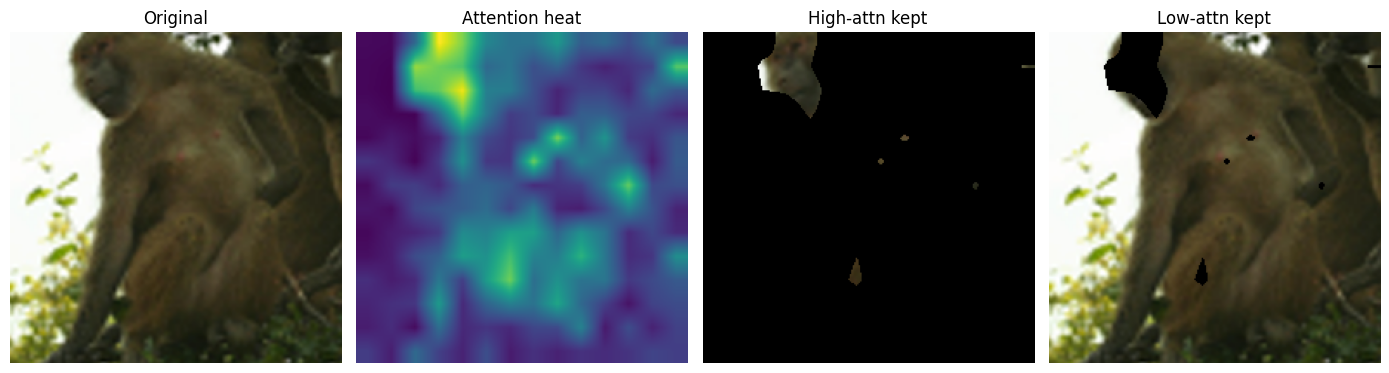

In [ ]:
def attention_to_mask(attn_map, threshold=0.7):
    """
    attn_map: [H,W] torch tensor in [0,1]
    returns binary mask [H,W] in {0,1}
    """
    attn_np = attn_map.cpu().numpy()
    mask = (attn_np >= threshold).astype(np.float32)
    return mask

def visualize_attention_mask_random(threshold=0.7):
    img_tensor, label = stl_test[np.random.randint(len(stl_test))]
    x = img_tensor.unsqueeze(0).to(device)

    attn = get_last_selfattention(model, x)[0]
    num_heads, N, _ = attn.shape
    num_patches = N - 1
    grid = int(math.sqrt(num_patches))

    cls_attn = attn[:, 0, 1:]
    cls_attn = cls_attn / (cls_attn.max(dim=-1, keepdim=True).values + 1e-6)
    cls_maps = cls_attn.reshape(num_heads, grid, grid)

    H, W = x.shape[2], x.shape[3]
    cls_maps_up = F.interpolate(
        cls_maps.unsqueeze(1),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(1)

    avg_map = cls_maps_up.mean(dim=0)
    avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min() + 1e-6)

    mask_high = attention_to_mask(avg_map, threshold=threshold)
    mask_low  = 1.0 - mask_high

    img_denorm = inv_normalize(img_tensor).clamp(0,1).cpu().numpy()
    mask_high_3c = np.stack([mask_high]*3, axis=0)
    mask_low_3c  = np.stack([mask_low]*3, axis=0)

    img_high = img_denorm * mask_high_3c
    img_low  = img_denorm * mask_low_3c

    img_pil = tensor_to_pil(img_tensor)
    img_high_pil = transforms.ToPILImage()(torch.from_numpy(img_high))
    img_low_pil  = transforms.ToPILImage()(torch.from_numpy(img_low))

    show_side_by_side(
        [img_pil, avg_map.cpu(), img_high_pil, img_low_pil],
        ["Original", "Attention heat", "High-attn kept", "Low-attn kept"],
        figsize=(14,4),
        cmap_list=[None, "viridis", None, None]
    )

visualize_attention_mask_random(threshold=0.7)


In [ ]:
@torch.no_grad()
def dino_features(model, x, layer_index=-1, use_cls=True):
    """
    Get features from an intermediate layer of DINO ViT.
    x: [B,3,H,W] normalized
    Returns: [B, C] (CLS or pooled patch tokens)
    """
    # returns list of layer outputs; we take the last by default
    feats = model.get_intermediate_layers(x, n=1)[0]   # [B, N, C]
    if use_cls:
        return feats[:, 0]                             # CLS token [B,C]
    else:
        return feats[:, 1:].mean(dim=1)                # mean over patches


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# 1) Extract train features
train_feats = []
train_labels = []

for imgs, labels in DataLoader(stl_train, batch_size=128, shuffle=False):
    imgs = imgs.to(device)
    f = dino_features(model, imgs)   # [B, C]
    train_feats.append(f.cpu())
    train_labels.append(labels)

train_feats = torch.cat(train_feats, dim=0).numpy()
train_labels = torch.cat(train_labels, dim=0).numpy()
print("Train features:", train_feats.shape)

# 2) Fit k-NN
knn = KNeighborsClassifier(n_neighbors=20, metric="cosine")
knn.fit(train_feats, train_labels)

# 3) Extract test features + evaluate
test_feats = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    f = dino_features(model, imgs)
    test_feats.append(f.cpu())
    test_labels.append(labels)

test_feats = torch.cat(test_feats, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

acc = (knn.predict(test_feats) == test_labels).mean()
print(f"k-NN accuracy on STL-10 using DINO embeddings: {acc*100:.2f}%")


Train features: (5000, 384)
k-NN accuracy on STL-10 using DINO embeddings: 53.22%


In [ ]:
# Dimension of DINO features
with torch.no_grad():
    sample_x, _ = next(iter(train_loader))
    sample_x = sample_x.to(device)
    feat_dim = dino_features(model, sample_x).shape[1]
feat_dim


384

In [ ]:
linear_head = nn.Linear(feat_dim, 10).to(device)  # STL-10 has 10 classes
optimizer = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [11]:
def train_linear_probe(epochs=10):
    model.eval()
    linear_head.train()

    for ep in range(epochs):
        total_loss = 0
        total_correct = 0
        total_count = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                feats = dino_features(model, imgs)  # [B,C]

            logits = linear_head(feats)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_count += imgs.size(0)

        print(f"Epoch {ep+1}/{epochs} | Loss {total_loss/total_count:.4f} | "
              f"Train Acc {total_correct/total_count*100:.2f}%")

def eval_linear_probe():
    model.eval()
    linear_head.eval()
    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = dino_features(model, imgs)
            logits = linear_head(feats)
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_count += imgs.size(0)
    print(f"Linear probe test accuracy: {total_correct/total_count*100:.2f}%")

train_linear_probe(epochs=10)
eval_linear_probe()


Epoch 1/10 | Loss 1.4820 | Train Acc 38.72%
Epoch 2/10 | Loss 1.3564 | Train Acc 42.15%
Epoch 3/10 | Loss 1.2479 | Train Acc 45.83%
Epoch 4/10 | Loss 1.1623 | Train Acc 49.10%
Epoch 5/10 | Loss 1.0897 | Train Acc 52.36%
Epoch 6/10 | Loss 1.0281 | Train Acc 55.04%
Epoch 7/10 | Loss 0.9742 | Train Acc 57.61%
Epoch 8/10 | Loss 0.9308 | Train Acc 59.38%
Epoch 9/10 | Loss 0.8975 | Train Acc 60.41%
Epoch 10/10 | Loss 0.8719 | Train Acc 61.73%
Linear probe test accuracy: 55.48%


In [ ]:
# store train set features for retrieval
train_feats = []
train_labels = []
train_imgs_raw = []   # for visualization

for img_tensor, label in stl_train:
    x = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = dino_features(model, x)[0].cpu()
    train_feats.append(feat)
    train_labels.append(label)
    train_imgs_raw.append(img_tensor)  # still normalized

train_feats = torch.stack(train_feats, dim=0)  # [N,C]
train_labels = torch.tensor(train_labels)
print("Train feats:", train_feats.shape)


Train feats: torch.Size([5000, 384])


Query label: 7


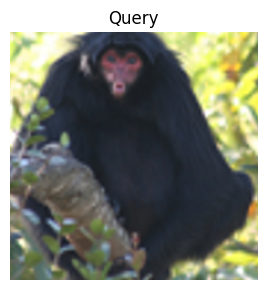

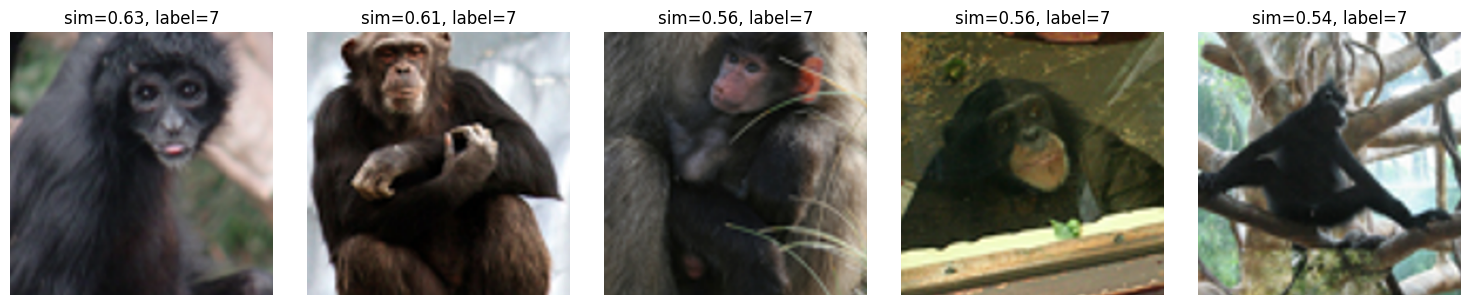

In [ ]:
@torch.no_grad()
def retrieve_similar_images(query_img_tensor, k=5):
    x = query_img_tensor.unsqueeze(0).to(device)
    q_feat = dino_features(model, x)[0].cpu()        # [C]

    # cosine similarity against all train features
    feats_norm = F.normalize(train_feats, dim=1)
    q_norm = F.normalize(q_feat.unsqueeze(0), dim=1)
    sims = (feats_norm @ q_norm.T).squeeze(1)        # [N]

    topk_vals, topk_idx = torch.topk(sims, k=k)
    return topk_idx, topk_vals

def visualize_retrieval_example():
    # pick random test image as query
    q_tensor, q_label = stl_test[np.random.randint(len(stl_test))]
    idxs, sims = retrieve_similar_images(q_tensor, k=5)

    q_pil = tensor_to_pil(q_tensor)

    retrieved_imgs = [tensor_to_pil(train_imgs_raw[i]) for i in idxs]
    titles = [f"sim={sims[i].item():.2f}, label={train_labels[idxs[i]].item()}"
              for i in range(len(idxs))]

    print("Query label:", q_label)
    show_side_by_side([q_pil], ["Query"], figsize=(3,3))
    show_side_by_side(retrieved_imgs, titles, figsize=(15,3))

visualize_retrieval_example()


In [12]:
from collections import defaultdict

def make_few_shot_subset(dataset, shots_per_class=5):
    class_to_imgs = defaultdict(list)
    for img, label in dataset:
        class_to_imgs[label].append((img, label))

    few_imgs = []
    few_labels = []
    for lbl, items in class_to_imgs.items():
        for img, lab in items[:shots_per_class]:
            few_imgs.append(img)
            few_labels.append(lab)

    return few_imgs, few_labels

few_imgs, few_labels = make_few_shot_subset(stl_train, shots_per_class=5)
print("Few-shot subset size:", len(few_imgs))

# extract features
few_feats = []
for img, lab in zip(few_imgs, few_labels):
    x = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = dino_features(model, x)[0].cpu()
    few_feats.append(feat)

few_feats = torch.stack(few_feats, dim=0).numpy()
few_labels = np.array(few_labels)

knn_few = KNeighborsClassifier(n_neighbors=1, metric="cosine")
knn_few.fit(few_feats, few_labels)

# evaluate on full test set
test_feats = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        f = dino_features(model, imgs).cpu()
    test_feats.append(f)
    test_labels.append(labels)

test_feats = torch.cat(test_feats, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

acc_few = (knn_few.predict(test_feats) == test_labels).mean()
print(f"Few-shot 5-shot 1-NN accuracy: {acc_few*100:.2f}%")


Few-shot subset size: 50
Few-shot 5-shot 1-NN accuracy: 50.34%
